In [748]:
import psycopg2
import requests
import nbimporter
import datetime
import sys
import numpy as np
import matplotlib.pyplot as plt
import Init_database as indb
from googletrans import Translator

In [1037]:
db_name="db_teld"
user_name="postgres"
password = "postgres"
host="169.229.157.40"
port="5432"
conn = indb.init_db(db_name, user_name, password, host, port)

In [6]:
try:
    cur = conn.cursor()
    stmt1 = "select ST_AsText(location) from tbl_app_eachstations"
    cur.execute(stmt1)
    station_loc1 = cur.fetchall()
    stmt2 = "select ST_X(location), ST_Y(location) from tbl_app_eachstations"
    cur.execute(stmt2)
    station_loc2 = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print(station_loc1[0])
print(station_loc2[0])

('POINT(116.26327 39.863907)',)
(116.26327, 39.863907)


In [1038]:
# #------- Request stationid which has user activities from db -------#
try:
    cur = conn.cursor()
    cur.execute("select distinct stationid from tbl_app_useractivity;")
    stationWithAct_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Number of stations with user activites: ", len(stationWithAct_list))
# #------- Request pilecode from db for states -------#
# staid_list = []
# for staid in stationWithAct_list:
#     staid_list.append(staid[0])
try:
    cur = conn.cursor()
#     sta_list = ['33a3c031-0a3a-417d-ba1b-53549bb08dc2']
    sta_list = ['2b3a35d4-cb94-4b8f-a47a-bbb054754066', '1d02640a-7f14-4fc3-baaf-60754a38fff7',
                'ac6cb946-5fff-491b-859e-55cc5f701657', 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66',
                'b134a159-16bd-4f5d-af1b-cd42599a3bab', '33a3c031-0a3a-417d-ba1b-53549bb08dc2', 
                'e4758edb-1183-4c51-887b-a52ca7abef3d', '13bdab71-110b-4448-a3c4-5c3113183546']
    #1. beijing hangkong jingmi jixie yanjiusuo chongdianzhan --'2b3a35d4-cb94-4b8f-a47a-bbb054754066',
    #2. beijing xijiao bingguan chongdianzhan -- '1d02640a-7f14-4fc3-baaf-60754a38fff7
    #3. beijing yangguanglicheng jiudian chongdianzhan --'ac6cb946-5fff-491b-859e-55cc5f701657',
    #4. beijing rongtao gongsi chongdianzhan -- '32d317a9-3d0c-4458-8357-89a2b3b1cf94'
    #5. beijing huairou qu yanshui lu -- 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66'
    
    #6. shenzhen hengjiang dasha chongdianzhan -- 'b134a159-16bd-4f5d-af1b-cd42599a3bab'
    #7. shenzhen yinxing gongyeyuan chongdianzhan -- '33a3c031-0a3a-417d-ba1b-53549bb08dc2'
    #8. shenzhe wanke jiulongshan chongdianzhan -- 'e4758edb-1183-4c51-887b-a52ca7abef3d'
    #9. shenzhen jingyuan dasha chongdianzhan -- '13bdab71-110b-4448-a3c4-5c3113183546'
    stmt = "select pilecode from tbl_APP_pilecode where staid in %s"
    cur.execute(stmt, (tuple(sta_list),))
    
#     stmt = "select pilecode from tbl_APP_pilecode where staid = 'dd4a3ddc-e1b0-4e2e-b7ca-faef627f4e66'"
#     cur.execute(stmt)
#     cur.execute("select pilecode from tbl_APP_pilecode")
    pillcode_list = cur.fetchall()
    cur.close()
except psycopg2.Error as e:
    print(e)
print("Nubmer of pills: ", len(pillcode_list))

Number of stations with user activites:  3899
Nubmer of pills:  86


In [966]:
# #------- Request Shenzhen charging pilecode from db for states -------#
try:
    cur = conn.cursor()
#     stmt1 = "select stationid from tbl_app_eachstations where tbl_app_eachstations.location && ST_MakeEnvelope(115.37916, 39.47148, 117.15623, 40.81726, 4326);"    
    stmt1 = "select stationid from tbl_app_eachstations where tbl_app_eachstations.location && ST_MakeEnvelope(113.85955, 22.50563, 114.17335, 22.69960, 4326) intersect select distinct stationid from tbl_app_useractivity;"
    cur.execute(stmt1)
    sta_list = cur.fetchall()
    sta_list_clean = []
    for sta in sta_list:
        sta_list_clean.append(sta[0])
except psycopg2.Error as e:
    print(e)
print("Shenzhen stations: " + str(len(sta_list_clean)))

Shenzhen stations: 63


# Create a charing station object

In [759]:
class Station(object):
    "This is a station object"
    num_pills = 0
    def __init__(self, stationid, score, pricescore, servicescore, 
                 stationname, stationaddress, location):
        self.id = stationid
        self.score = score
        self.pricescore = pricescore
        self.servicescore = servicescore
        self.name = stationname
        self.addr = stationaddress
        self.GPS = location
        self.pills = []
    def add_Pill(self, pill_obj):
        self.pills.append(pill_obj)
        self.num_pills += 1
    def delete_numPills(self):
#         if self.pills >= 1:
#             self.pills -= 1
        pass
    def check_pill(self, pillcode):
        for pill in self.pills:
            #if exist return True
            if pill.pillcode == pillcode:
                return True
        return False
    def get_maxPower(self):
        maxPower = 0
        for pill in self.pills:
            if pill.isfast == "Y":
                maxPower += 60 #kw
            else:
                maxPower += 7 #kw
        return maxPower
    def get_stationName_Eng(self):
        translator = Translator()
        return translator.translate(self.name).text

# Create a charging pill object

In [10]:
class Pill(Station):
    ult_data = None
    def __init__(self, pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station):
        self.pillcode = pillcode
        self.voltage = voltage
        self.description = description
        self.isfast = isfast
        self.chargingport = chargingport
        self.power = power
        self.pricedesc = pricedesc
        self.prices = prices
        self.station = station
    def update_ultData(self, ult_data_new):
        self.ult_data = ult_data_new

# Get data from db

In [12]:
# #------- Request one pill daily utilization data from db -------#
def get_pill_daily(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select statecode, statename, time from tbl_APP_state where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        ult_data = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return ult_data

In [13]:
# #------- Request the pill details from db -------#
def get_pill_details(pillcode):
    try:
        cur = conn.cursor()
        stmt = "select voltage, description, isfast, chargingport, power, pricedesc, prices from tbl_app_piles where pillcode='{}'".format(pillcode)
        cur.execute(stmt)
        pill_details = cur.fetchall()
        cur.close()
        return pill_details
    except psycopg2.Error as e:
        print(e)

In [14]:
# #------- Request the station details from db -------#
def get_sta_details(stationid):
    try:
        cur = conn.cursor()
        stmt = "select servicescore, score, pricescore, stationname, stationaddress, ST_X(location), ST_Y(location) from tbl_app_eachstations where stationid='{}'".format(stationid)
        cur.execute(stmt)
        sta_details = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return sta_details
    

In [15]:
# #------- Request pillcodes from same station from db -------#
def get_pillcodes(stationid=sta_list[0]):
    try:
        cur = conn.cursor()
        stmt = "select pillcode from tbl_app_piles where staid='{}'".format(stationid)
        cur.execute(stmt)
        pillcode_list = cur.fetchall()
        cur.close()
    except psycopg2.Error as e:
        print(e)
    return pillcode_list

## Get target pillcode list, pill details and station details list

In [976]:
def get_pill_station_details(sta_list):
    pillcode_list = []
    pill_details_list = []
    sta_details_list = []
    for staid in sta_list:
        pillcode_list.append(get_pillcodes(staid))
        pill_details_list.append(get_pill_details(pillcode_list[0][0][0]))
        sta_details_list.append(get_sta_details(staid))
    return pillcode_list, pill_details_list, sta_details_list

In [807]:
# 深圳银星工业园充电站
pillcode_list_YinXing, pill_details_YinXing, sta_details_YinXing = get_pill_station_details([sta_list[-3]])

#____________________________#
#All stations in the sta_list
pillcode_list, pill_details_list, sta_details_list = get_pill_station_details(sta_list)

In [812]:
for _ in pillcode_list_YinXing[0]:
    print(_[0])
print("__________________")
print("pill details: \n")
for _ in pill_details_YinXing[0][0]:
    print(_)
print("__________________")
print("station details: \n")
for _ in sta_details_YinXing[0][0]:
    print(_)

4403060011105
4403060011103
4403060011109
4403060011201
4403060011106
4403060011203
4403060011202
4403060011108
4403060011210
4403060011102
4403060011107
4403060011110
4403060011207
4403060011209
4403060011101
4403060011104
4403060011206
4403060011205
4403060011204
__________________
pill details: 


00:00~24:00:0.700000:00~24:00:1.0000
N
国标2011 

电费:00:00~24:00:1.0000;服务费:00:00~24:00:0.7000
[{u'servicePrice': u'0.7000', u'timeRange': u'00:00-24:00', u'electricPrice': u'1.0000', u'startTime': u'00:00'}]
__________________
station details: 

3.6
4.3
3.6
深圳银星工业园充电站
广东省深圳市宝安区龙华新区观光路1301号银星高科技工业园
114.04726
22.7296


# Functions for construction stations and pills

In [22]:
def init_sta(stationid, score, pricescore, 
               servicescore, stationname, stationaddress, x, y):
    """
    Data cleansing + passing into Station object to initiate
    """
    location  = (x, y)
    station = Station(stationid, score, pricescore, servicescore, stationname, stationaddress, location)
    return station

In [23]:
def constr_pill(pillcode, voltage, description, isfast, 
                chargingport, power, pricedesc, prices, station):
    """
    Data cleansing + passing into Pill object to initiate
    """
    pill = Pill(pillcode, voltage, description, isfast, chargingport, power, pricedesc, prices, station)
    return pill

In [881]:
def constr_sta(pillcode_list, station):
    """
    Construct full station and pills included
    """
    for pillcode in pillcode_list:
        pill_details = get_pill_details(pillcode=pillcode[0])
        if not station.check_pill(pillcode[0]):
            pill = constr_pill(pillcode[0], pill_details[0][0], pill_details[0][1], pill_details[0][2],
                  pill_details[0][3], pill_details[0][4], pill_details[0][5], pill_details[0][6], station)
            station.add_Pill(pill)
    return station

In [882]:
def update_ultData(station):
    for pill in station.pills:
        pillcode = pill.pillcode
        ult_data = get_pill_daily(pillcode)
        pill.update_ultData(ult_data)
    return station

## Initiate station object

In [979]:
def init_station_obj(sta_list, sta_details_list):
    staObject_list = []
    for i, staid in enumerate(sta_list):
        station_obj = init_sta(staid, sta_details_list[i][0][0], sta_details_list[i][0][1], sta_details_list[i][0][2],
                          sta_details_list[i][0][3], sta_details_list[i][0][4], sta_details_list[i][0][5], sta_details_list[i][0][6])
        staObject_list.append(station_obj)
    return staObject_list

In [893]:
staObject_list = init_station_obj(sta_list)
YinXing_IndustrialPark_sta = init_station_obj([staid_list[-3]])

In [885]:
YinXing_IndustrialPark_sta =init_sta(staid_list[-3], sta_details_YinXing[0][0], 
                                     sta_details_YinXing[0][0][1], sta_details_YinXing[0][0][2],
                                     sta_details_YinXing[0][0][3], sta_details_YinXing[0][0][4], 
                                     sta_details_YinXing[0][0][5], sta_details_YinXing[0][0][6])
staObject_list = []
for i, staid in enumerate(sta_list):
    station_obj = init_sta(staid, sta_details_list[i][0][0], sta_details_list[i][0][1], sta_details_list[i][0][2],
                      sta_details_list[i][0][3], sta_details_list[i][0][4], sta_details_list[i][0][5], sta_details_list[i][0][6])
    staObject_list.append(station_obj)

## Construct fully a station object with pills included

In [886]:
def constr_station_objFull(staObject_list, pillcode_list):
    for i, pillcodes in enumerate(pillcode_list):
        staObject_list[i] = constr_sta(pillcodes, staObject_list[i])
    return staObject_list

In [896]:
staObject_list = constr_station_objFull(staObject_list, pillcode_list)
YinXing_IndustrialPark_sta = constr_station_objFull([YinXing_IndustrialPark_sta[0]], pillcode_list_YinXing)

In [ ]:
YinXing_IndustrialPark_sta = constr_sta(pillcode_list_YinXing[0], YinXing_IndustrialPark_sta)
YinXing_IndustrialPark_sta.pills[0].pillcode

for i, pillcodes in enumerate(pillcode_list):
    staObject_list[i] = constr_sta(pillcodes, staObject_list[i])

In [898]:
print(YinXing_IndustrialPark_sta[0].num_pills)
print(staObject_list[0].num_pills)

19
14


## Update daily utilization data for the station

In [901]:
def update_daily_ultData(staObject_list):
    for i in range(len(staObject_list)):
        staObject_list[i] = update_ultData(staObject_list[i])
    return staObject_list

In [902]:
staObject_list = update_daily_ultData(staObject_list)
YinXing_IndustrialPark_sta = update_daily_ultData(YinXing_IndustrialPark_sta)

In [ ]:
YinXing_IndustrialPark_sta = update_ultData(YinXing_IndustrialPark_sta[0])
for i in range(len(staObject_list)):
    staObject_list[i] = update_ultData(staObject_list[i])

In [904]:
print(YinXing_IndustrialPark_sta[0].pills[0].ult_data[0][2])

print(staObject_list[0].pills[0].ult_data[0][2])
print(staObject_list[0].name)

2017-09-10 23:35:34.441082-07:00
2017-09-10 23:07:42.807157-07:00
北京航空精密机械研究所充电站


## Data Visualization - Plotting

In [1051]:
def convert_day(date_power_sta_list):
    """
    Map all the day of the dates to the same day to plot
    """
    if len(date_power_sta_list[0]) > 0:
        day = date_power_sta_list[0][0].day
        for i in range(1, len(date_power_sta_list)):
            for j in range(len(date_power_sta_list[i])):
                date_power_sta_list[i][j] = date_power_sta_list[i][j].replace(day=day)    
    return date_power_sta_list

In [1010]:
def create_timeOfDay(date_power_sta_list, timestamp=15):
    """
    timestamp - assuming multiple of 15 (minutes)
    """
    if len(date_power_sta_list[0]) > 0:
        timeOfDay = []
        pts_per_min = int(60/timestamp)
        minutes = [timestamp*i for i in range(pts_per_min)]
        year = date_power_sta_list[0][0].year
        month = date_power_sta_list[0][0].month
        day = date_power_sta_list[0][0].day
        for i in range(24):
            for minute in minutes:
                date_obj = datetime.datetime(year, month, day, i, minute, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
                timeOfDay.append(date_obj)
    return timeOfDay

In [1061]:
def find_timeIdx(dateTime, timestamp=15):
    """
    timestamp - assuming multiple of 15 (minutes)
    """
    if timestamp == 15:
        if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day-1, 23, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)):
            return 0
        elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 52, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)):
            return dateTime.hour*4
        else:
            if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 7, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)): 
                return dateTime.hour*4 + 1
            elif datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 22, 31, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 37, 30, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)): 
                return dateTime.hour*4 + 2
            else: 
                return dateTime.hour*4 + 3
    elif timestamp == 30:
        if dateTime.hour == 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day-1, 23, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)):
            return 0
        elif dateTime.hour != 0 and datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour-1, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)):
            return dateTime.hour*2
        else:
            if datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 15, 0, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < dateTime and dateTime < datetime.datetime(dateTime.year, dateTime.month, dateTime.day, dateTime.hour, 45, 1, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)): 
                return dateTime.hour*2 + 1
            else:
                if dateTime.hour == 23:
                    return dateTime.hour*2 + 1
                return dateTime.hour*2 + 2

In [957]:
def map_powerOfDay(date_power_sta_list, occupy_power_sta_list, length_prior_list, timestamp):
    """
    timestamp - assuming multiple of 15 (minutes)
    """
    buckets = int(24*60/timestamp)
    timeOfPower = [[] for i in range(buckets)]
    for pwr_counter, occupy_power_sta in enumerate(occupy_power_sta_list):
        for time_counter, date in enumerate(date_power_sta_list[pwr_counter]):
            try:
                index = find_timeIdx(date, timestamp)
                timeOfPower[index].append(occupy_power_sta[length_prior_list[pwr_counter]:length_prior_list[pwr_counter]+len(date_power_sta_list[pwr_counter])][time_counter])
            except:
                print(date)
                print(sys.exc_info())
    return timeOfPower

In [950]:
def get_avg_timeOfPower(timeOfPower, timestamp):
    """
    timestamp - assuming multiple of 15 (minutes)
    """
    buckets = int(24*60/timestamp)
    avg_timeOfPower = []
    for i in range(buckets):
        if sum(timeOfPower[i]) == 0:
            timeOfPower[i] = [0]
    #     print(timeOfPower[i])
        avg_timeOfPower.append(np.average(timeOfPower[i]))
    return avg_timeOfPower

### Operation Code Plot

809
809


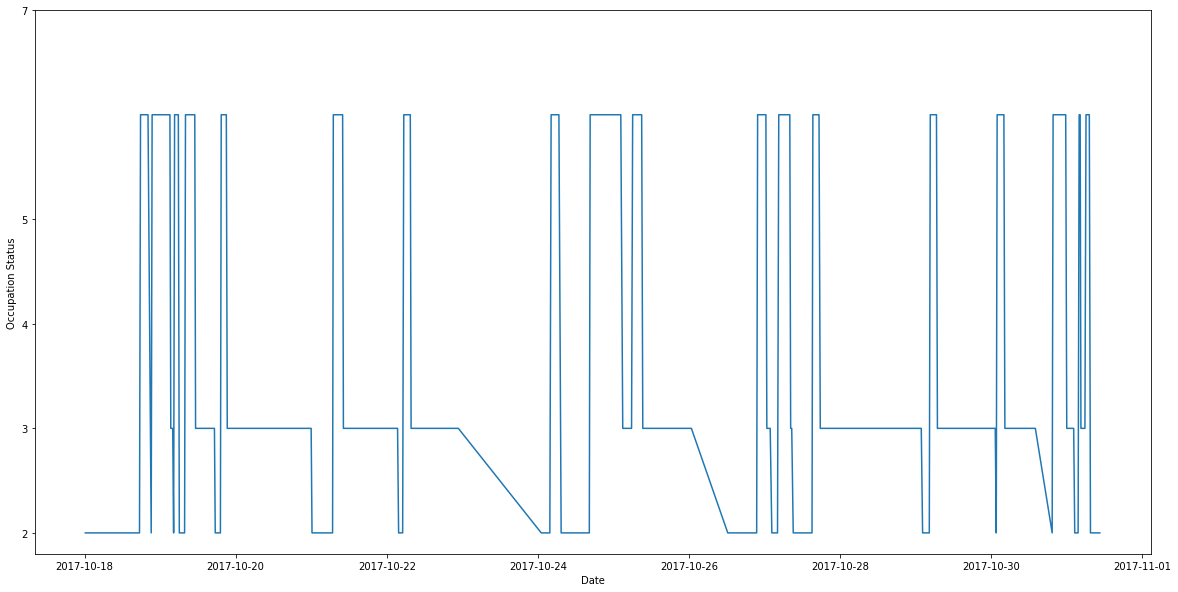

In [312]:
day_lowerBound = 18

occupy_code = [int(data[0]) for data in YinXing_IndustrialPark_sta[0].pills[0].ult_data if 
          datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < data[2]]
date_code = [data[2] for data in YinXing_IndustrialPark_sta[0].pills[0].ult_data if 
        datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) < data[2]]
print(len(occupy_code))
print(len(date_code))

plt.figure(1, figsize=(20,10))
plt.plot(date_code, occupy_code)
plt.xlabel("Date")
plt.ylabel("Occupation Status")
plt.yticks(np.linspace(2,7,5,dtype=int))
plt.show()

### Operation Power Plot - one single pill

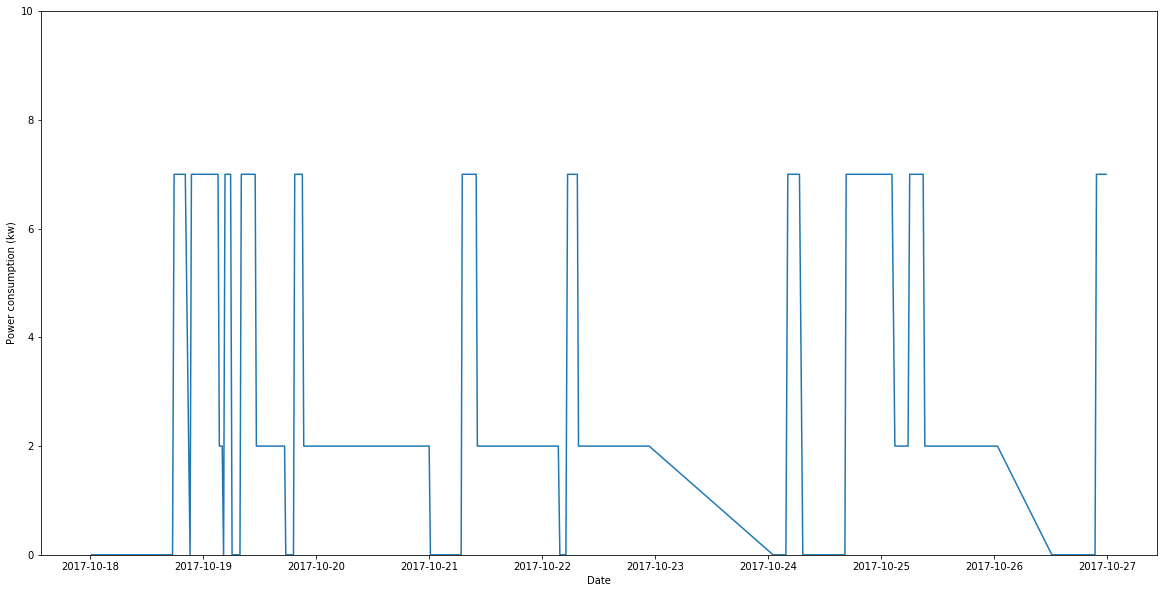

In [905]:
day_lowerBound = 18
day_upperBound = 27

occupy_power_pill = []
power_02 = 0
power_03 = 2
power_06 = 7
date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None)) 
for data in YinXing_IndustrialPark_sta[0].pills[0].ult_data:
    if int(data[0]) == 2 and  date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_pill.append(power_02)
    elif int(data[0]) == 3 and date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_pill.append(power_03)
    elif int(data[0]) == 6 and date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_pill.append(power_06)
date_power_pill = [data[2] for data in YinXing_IndustrialPark_sta[0].pills[0].ult_data if 
        date_lowerBound < data[2] and date_upperBound > data[2]]

plt.figure(2, figsize=(20,10))
plt.plot(date_power_pill, occupy_power_pill)
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.ylim((0,10))
plt.show()

### Operation Power Plot - one station

In [906]:
# Check number of data before a time
def check_num_prior(station, date_upperBound):
    length_prior = []
    for pill in station.pills:
        length = 0
        for data in pill.ult_data:
            if data[2] < date_upperBound:
                length+=1
        length_prior.append(length)
    return max(length_prior)
# Check number of data in one period
def check_num_btw(station, date_lowerBound, date_upperBound):
    length_period = []
    for pill in station.pills:
        length = 0
        for data in pill.ult_data:
            if date_lowerBound < data[2] and date_upperBound > data[2]:
                length+=1
        length_period.append(length)
    print("max in between length: ",max(length_period))
    return max(length_period)
# Total utilization data length
def check_num_tot(station):
    length_total = []
    for pill in station.pills:
        length_total.append(len(pill.ult_data))
    return max(length_total)

In [669]:
day_lowerBound = 19
day_upperBound = 21

date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
length_prior = check_num_prior(station, date_lowerBound)

# date_lowerBound = datetime.datetime(2017, 10, 18, 12, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
# date_upperBound = datetime.datetime(2017, 10, 23, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
# length_period = check_num_btw(YinXing_IndustrialPark_sta, date_lowerBound, date_upperBound)

length_total = check_num_tot(station)

occupy_power_sta = np.zeros(length_total)
power_02 = 0
#ac charger power
power_ac_03 = 2  #kw
power_ac_06 = 7  #kw
#dc charge power
power_dc_03 = 40 #kw
power_dc_06 = 15 #kw

for pill in station.pills:
    for i, data in enumerate(pill.ult_data):
        if int(data[0]) == 2 and  date_lowerBound < data[2] and date_upperBound > data[2]:
            occupy_power_sta[i]+=(power_02)
        elif int(data[0]) == 3 and date_lowerBound < data[2] and date_upperBound > data[2]:
            if len(pill.power) is 0:
                occupy_power_sta[i]+=(power_ac_03)
            else:
                occupy_power_sta[i]+=(power_dc_03)
        elif int(data[0]) == 6 and date_lowerBound < data[2] and date_upperBound > data[2]:
            if len(pill.power) is None:
                occupy_power_sta[i]+=(power_ac_06)
            else:
                occupy_power_sta[i]+=(power_dc_06)
date_power_sta = [data[2] for data in station.pills[0].ult_data if 
            date_lowerBound < data[2] and date_upperBound > data[2]]

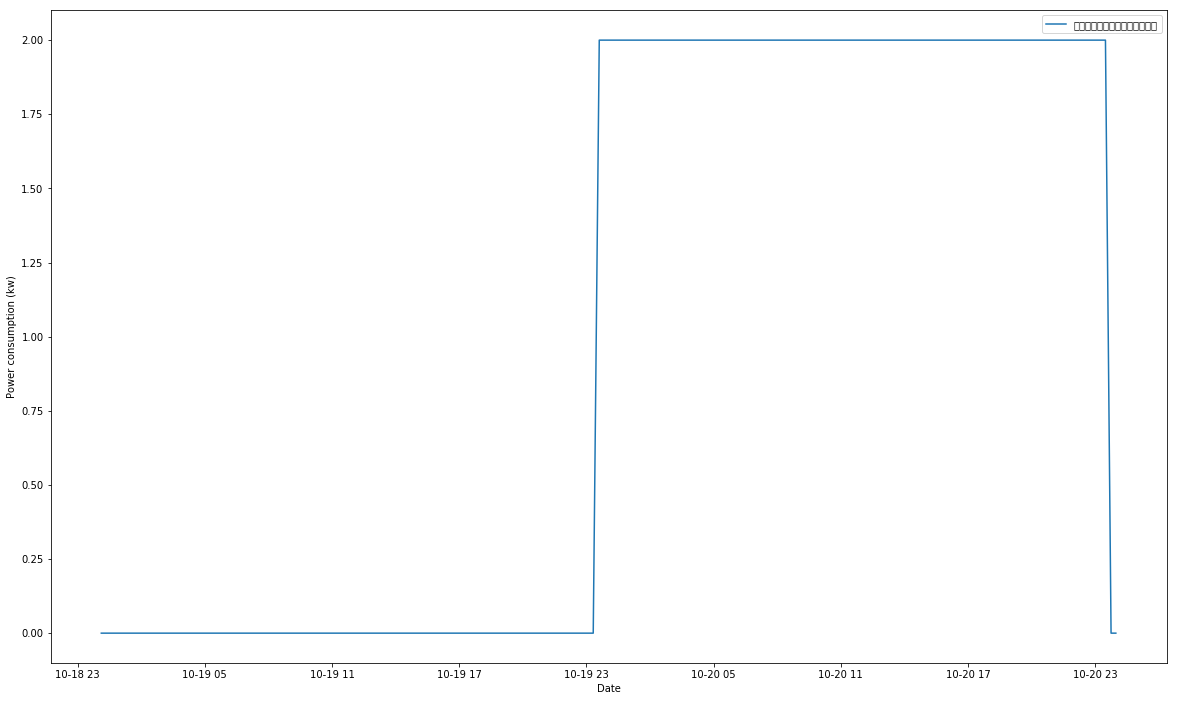

In [670]:
plt.figure(2, figsize=(20,12))
plt.plot(date_power_sta, occupy_power_sta[length_prior:length_prior+len(date_power)], label=station.name)
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.legend()
plt.show()

### Operation Power Plot - eight stations

In [907]:
day_lowerBound = 10
day_upperBound = 17
date_upperBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))

occupy_power_sta = [np.zeros(max(length_total_list))]*len(sta_list)

for station in staObject_list:
    length_prior = check_num_prior(station, date_upperBound)
    length_prior_list.append(length_prior)
print("max prior length: ", max(length_prior_list))

length_total_list = []
for station in staObject_list:
    length_total = check_num_tot(station)
    length_total_list.append(length_total)
print("max total length: ", max(length_total_list))


power_02 = 0
#ac charger power
power_ac_03 = 2  #kw
power_ac_06 = 7  #kw
#dc charge power
power_dc_03 = 40 #kw
power_dc_06 = 15 #kw
date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))

occupy_power_sta_list = []
date_power_sta_list = []
length_prior_list = []
for counter, station in enumerate(staObject_list):
# for counter in range(1,3):
    length_prior_list.append(check_num_prior(station, date_lowerBound))
    length_total = check_num_tot(station)
    occupy_power_sta = np.zeros(length_total)
    
    for pill in station.pills:
#     for pill in staObject_list[counter].pills:
        for i, data in enumerate(pill.ult_data):
            if int(data[0]) == 2 and date_lowerBound < data[2] and date_upperBound > data[2]:
                occupy_power_sta[i]+=(power_02)
#                 print("counter is ", counter)
#                 print("i is ", i)
#                 print(occupy_power_sta[counter][i])
            elif int(data[0]) == 3 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is 0:
                    occupy_power_sta[i]+=(power_ac_03)
                else:
                    occupy_power_sta[i]+=(power_dc_03)
            elif int(data[0]) == 6 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is None:
                    occupy_power_sta[i]+=(power_ac_06)
                else:
                    occupy_power_sta[i]+=(power_dc_06)
    occupy_power_sta_list.append(occupy_power_sta)
    date_power_sta = [data[2] for data in station.pills[0].ult_data if 
            date_lowerBound < data[2] and date_upperBound > data[2]]
    date_power_sta_list.append(date_power_sta)

max prior length:  1620
max total length:  1918


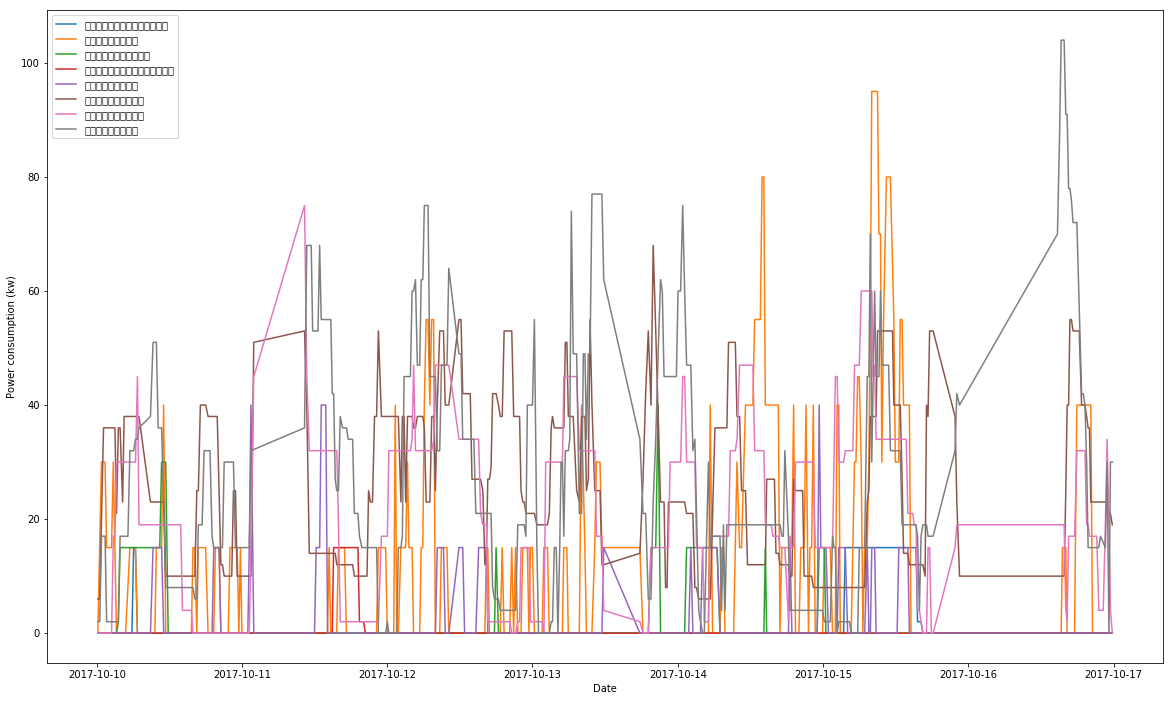

北京航空精密机械研究所充电站


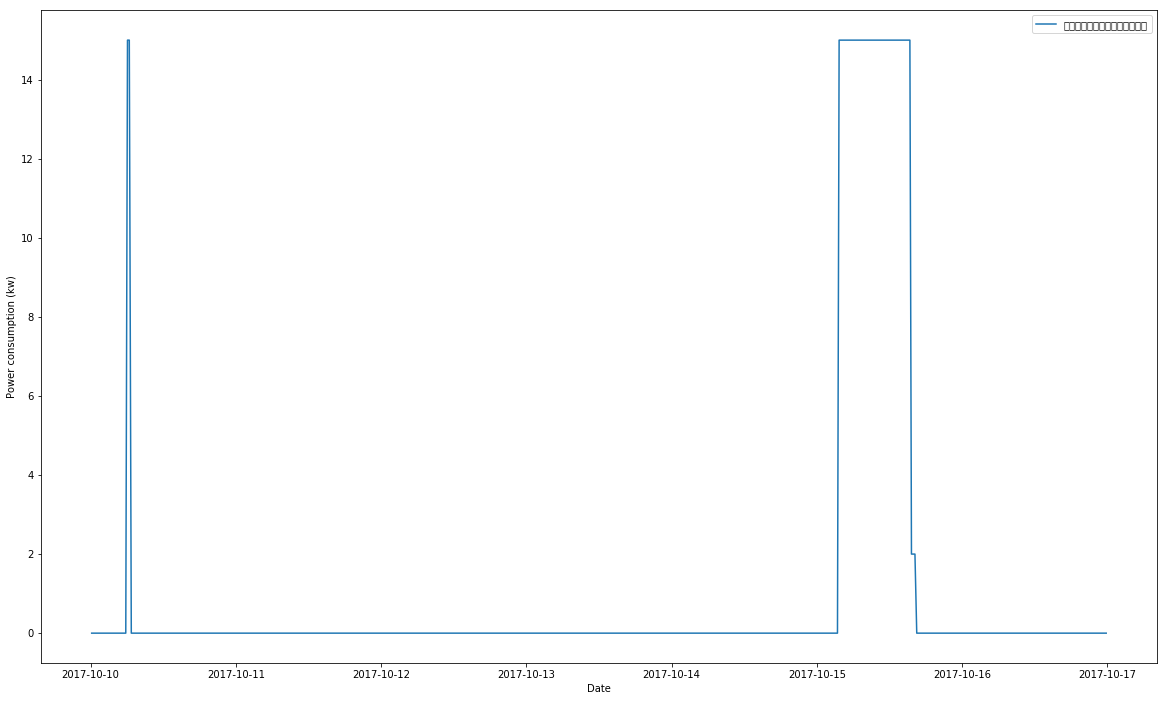

北京西郊宾馆充电站


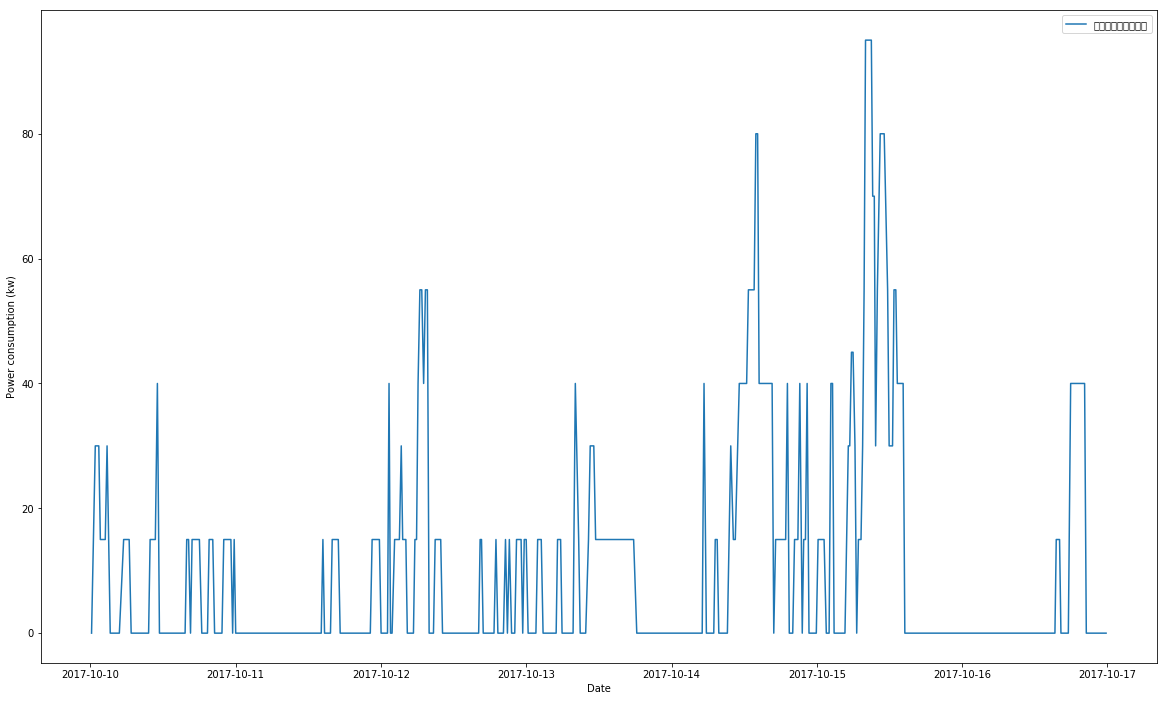

北京阳光丽城酒店充电站


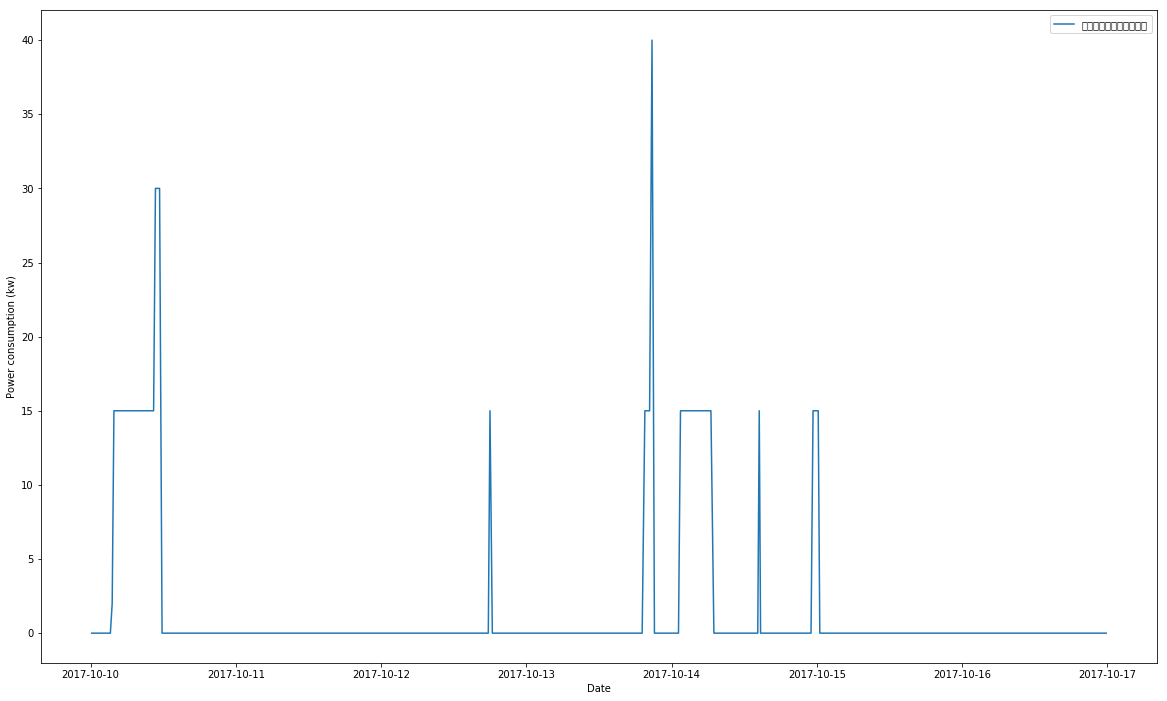

北京元亨苑林山庄有限公司充电站


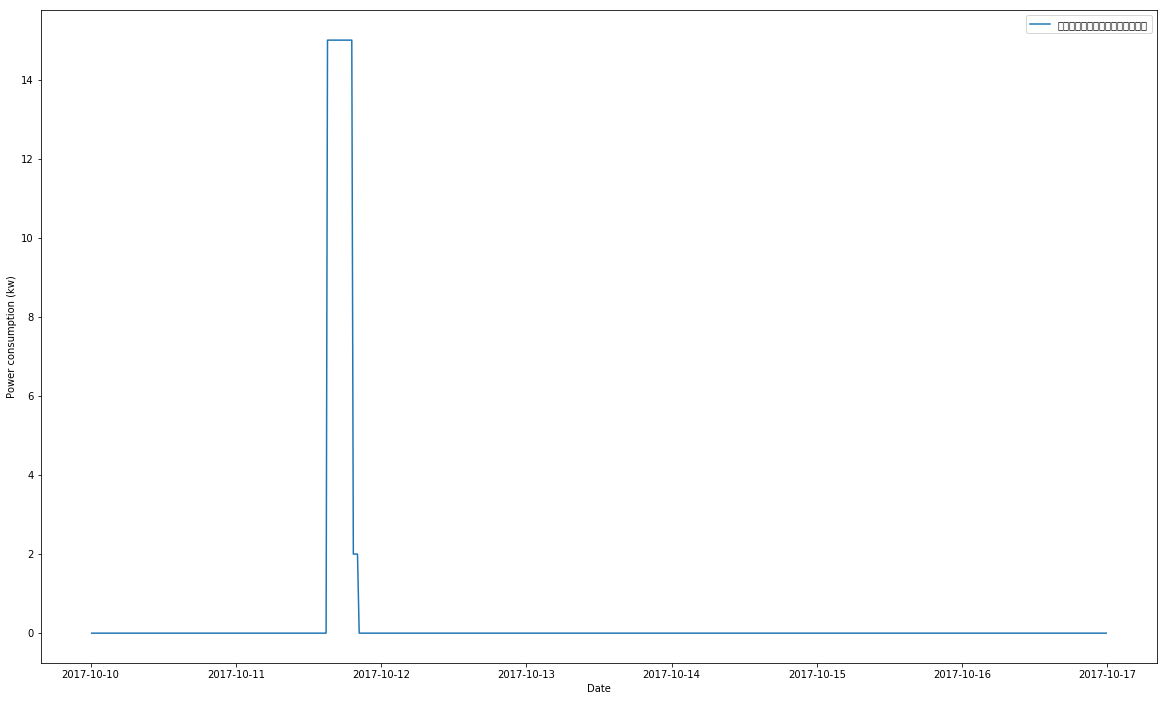

深圳恒江大厦充电站


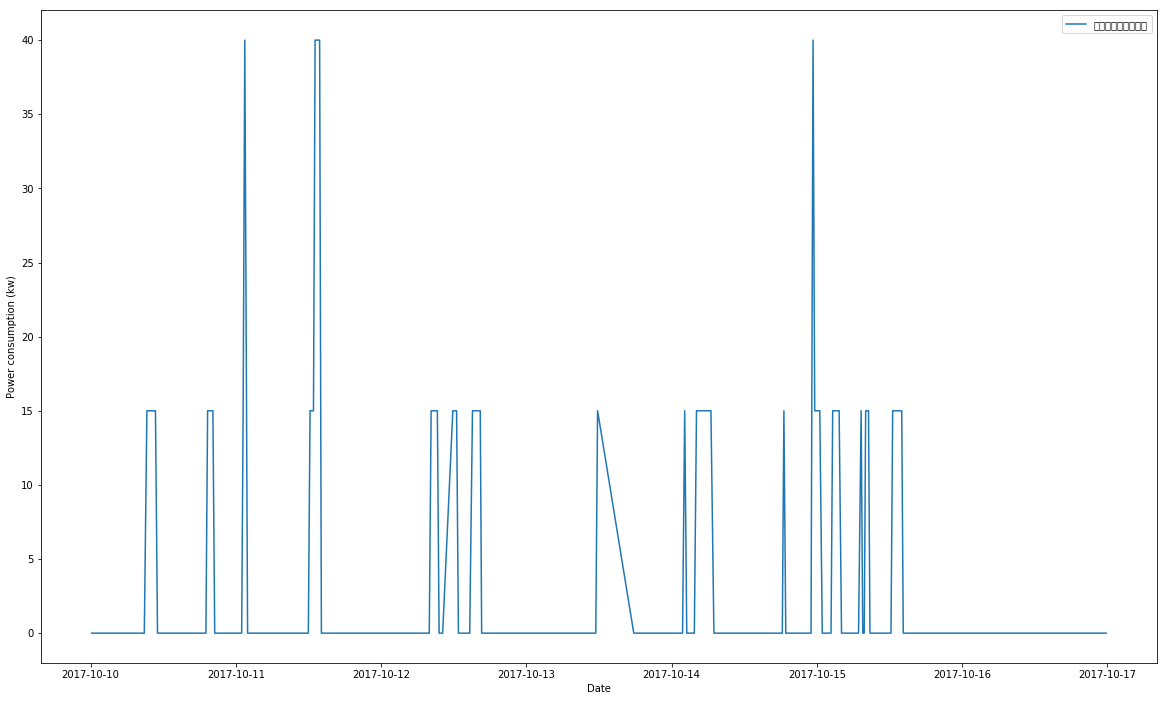

深圳银星工业园充电站


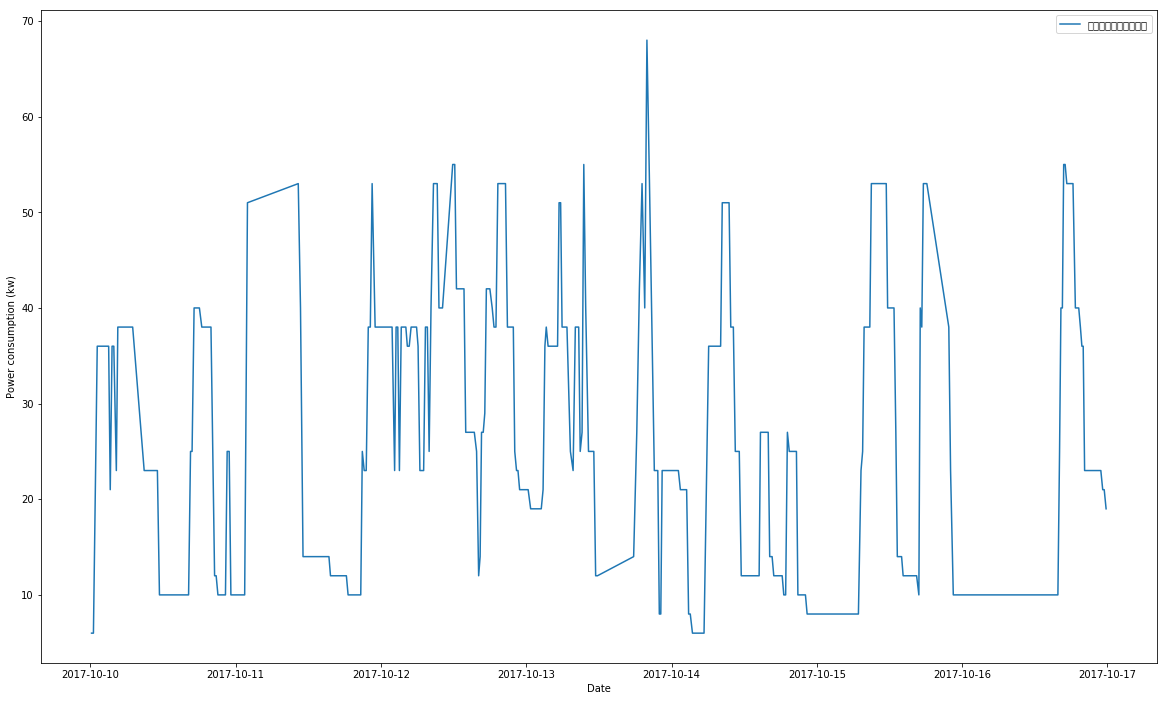

深圳万科九龙山充电站


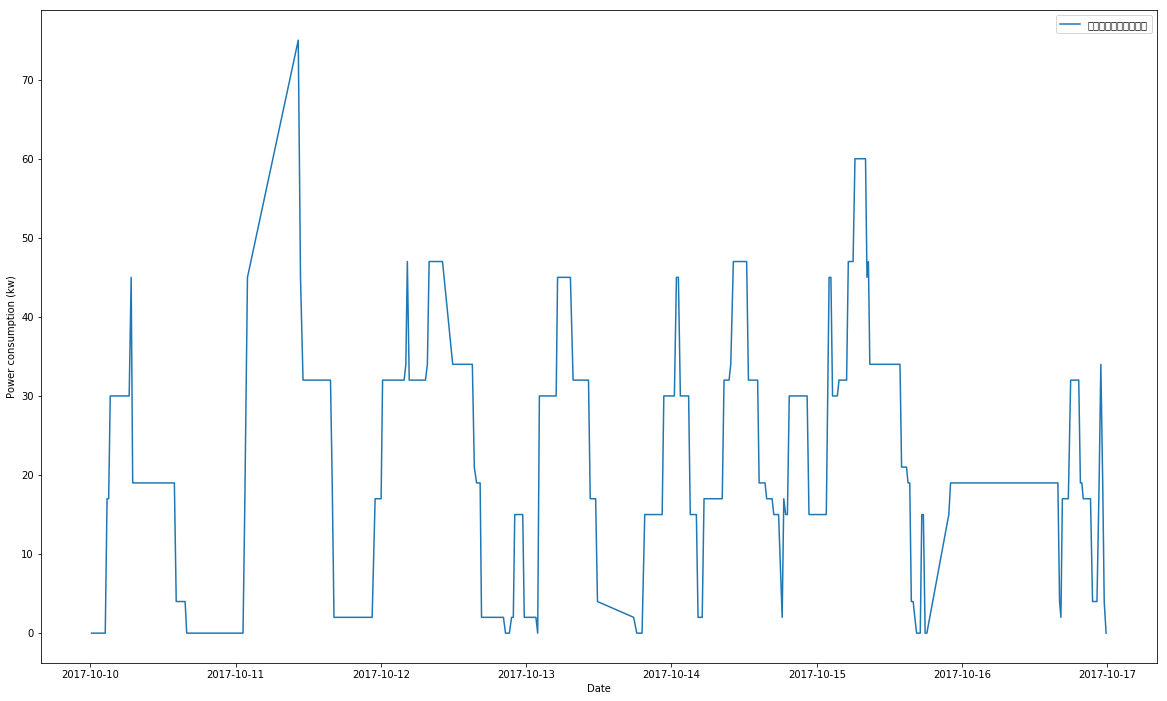

深圳景元大厦充电站


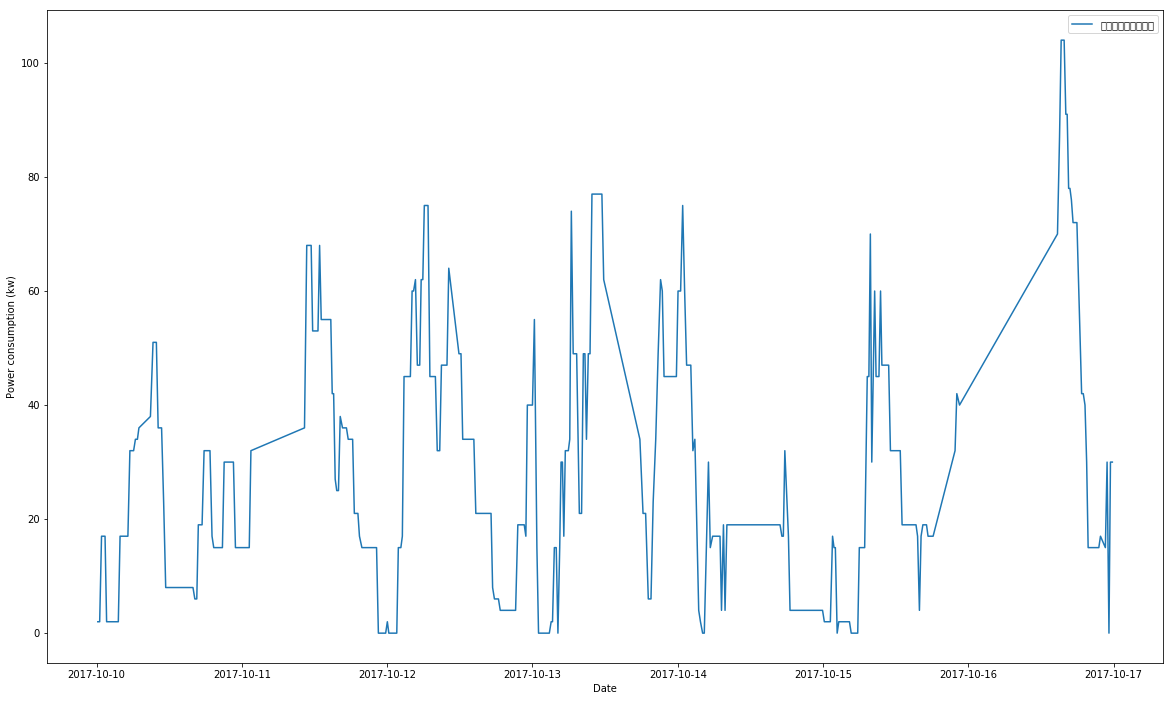

In [908]:
plt.close()
plt.figure(10, figsize=(20,12))
for counter, station in enumerate(staObject_list):
    plt.plot(date_power_sta_list[counter], occupy_power_sta_list[counter][length_prior_list[counter]:length_prior_list[counter]+len(date_power_sta_list[counter])], label=station.name)
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.legend()
plt.show()
for counter, station in enumerate(staObject_list):
    plt.figure(counter, figsize=(20,12))
    print(station.name)
    plt.plot(date_power_sta_list[counter], occupy_power_sta_list[counter][length_prior_list[counter]:length_prior_list[counter]+len(date_power_sta_list[counter])], label=station.name)
    plt.xlabel("Date")
    plt.ylabel("Power consumption (kw)")
    plt.legend()
    plt.show()
# plt.show()

### Operation Daily Power Plot - one single station

In [909]:
station = YinXing_IndustrialPark_sta[0]
day_lowerBound = 8
# day_upperBound = 21
occupy_power_sta_list = []
date_power_sta_list = []
length_prior_list = []
for day in range(20):
    day_lowerBound += 1
    day_upperBound = day_lowerBound+1
    date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
    date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
    
    length_prior = check_num_prior(station, date_lowerBound)
    length_prior_list.append(length_prior)
    length_total = check_num_tot(station)

    occupy_power_sta = np.zeros(length_total)
    power_02 = 0
    #ac charger power
    power_ac_03 = 2  #kw
    power_ac_06 = 7  #kw
    #dc charge power
    power_dc_03 = 40 #kw
    power_dc_06 = 15 #kw
    for pill in station.pills:
        for i, data in enumerate(pill.ult_data):
            if int(data[0]) == 2 and  date_lowerBound < data[2] and date_upperBound > data[2]:
                occupy_power_sta[i]+=(power_02)
            elif int(data[0]) == 3 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is 0:
                    occupy_power_sta[i]+=(power_ac_03)
                else:
                    occupy_power_sta[i]+=(power_dc_03)
            elif int(data[0]) == 6 and date_lowerBound < data[2] and date_upperBound > data[2]:
                if len(pill.power) is None:
                    occupy_power_sta[i]+=(power_ac_06)
                else:
                    occupy_power_sta[i]+=(power_dc_06)
    occupy_power_sta_list.append(occupy_power_sta)
    date_power_sta = [data[2] for data in station.pills[0].ult_data if 
                date_lowerBound < data[2] and date_upperBound > data[2]]
    date_power_sta_list.append(date_power_sta)

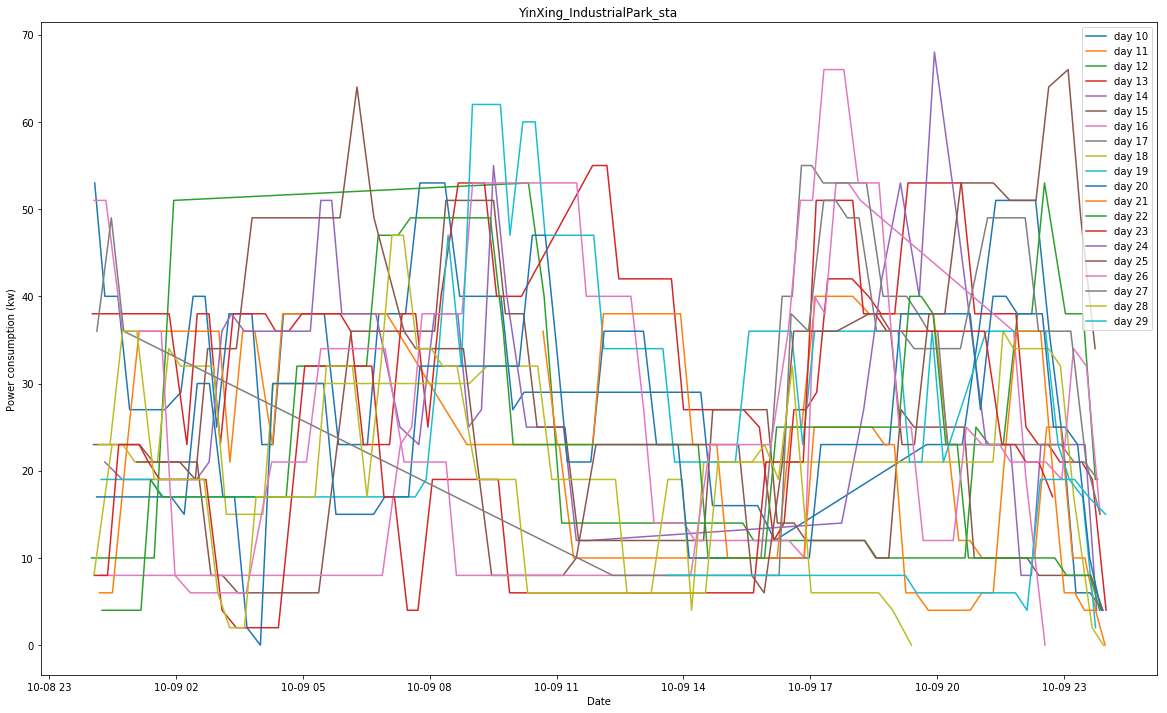

In [911]:
date_power_sta_list = convert_day(date_power_sta_list)
plt.figure(1, figsize=(20,12))
for counter in range(len(occupy_power_sta_list)):
    plt.plot(date_power_sta_list[counter], occupy_power_sta_list[counter][length_prior_list[counter]:length_prior_list[counter]+len(date_power_sta_list[counter])], label="day {}".format(9+counter+1))
plt.xlabel("Date")
plt.ylabel("Power consumption (kw)")
plt.legend()
plt.title("YinXing_IndustrialPark_sta")
plt.show()

In [916]:
timeOfPower = map_powerOfDay(date_power_sta_list, occupy_power_sta_list, length_prior_list)
timeOfDay = create_timeOfDay()

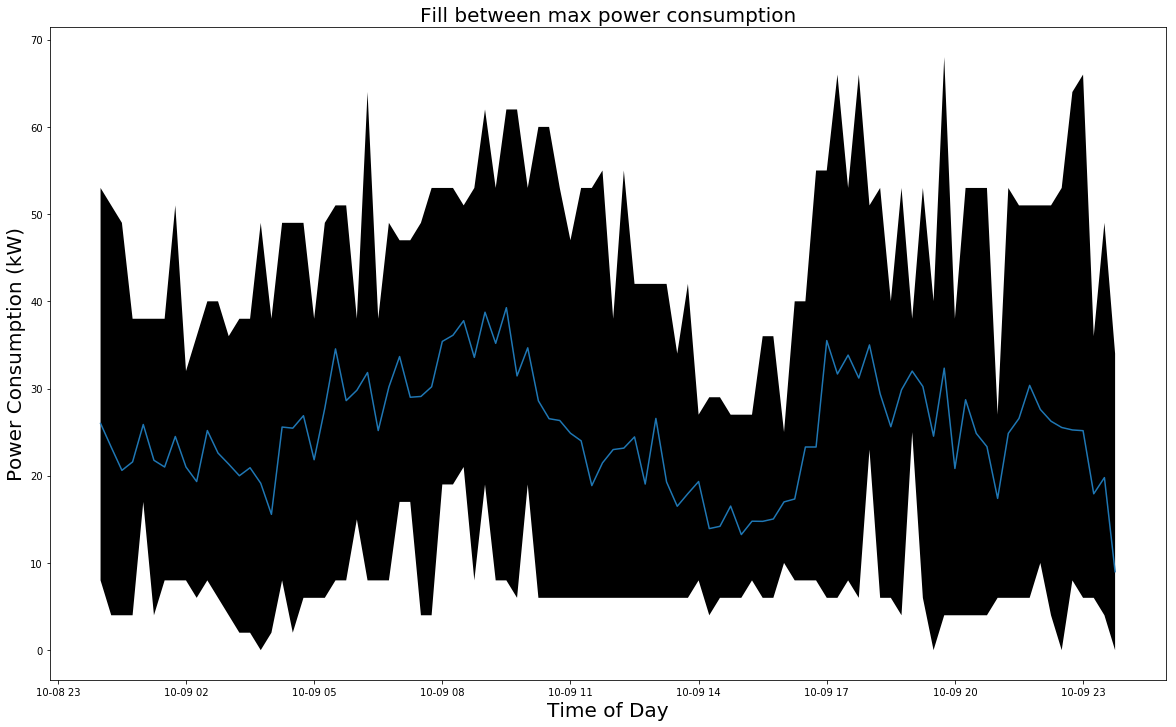

In [917]:
# Plot full power consumption data
avg_timeOfPower = get_avg_timeOfPower(timeOfPower)
plt.figure(1, figsize=(20,12))
plt.plot(timeOfDay, avg_timeOfPower)
plt.fill_between(timeOfDay, [max(timeOfPower[i]) for i in range(96)], [min(timeOfPower[i]) for i in range(96)], facecolor='black')
plt.xlabel("Time of Day", fontdict={'fontsize':20})
plt.ylabel("Power Consumption (kW)", fontdict={'fontsize':20})
plt.title("Fill between max power consumption", fontdict={'fontsize':20})
plt.show()

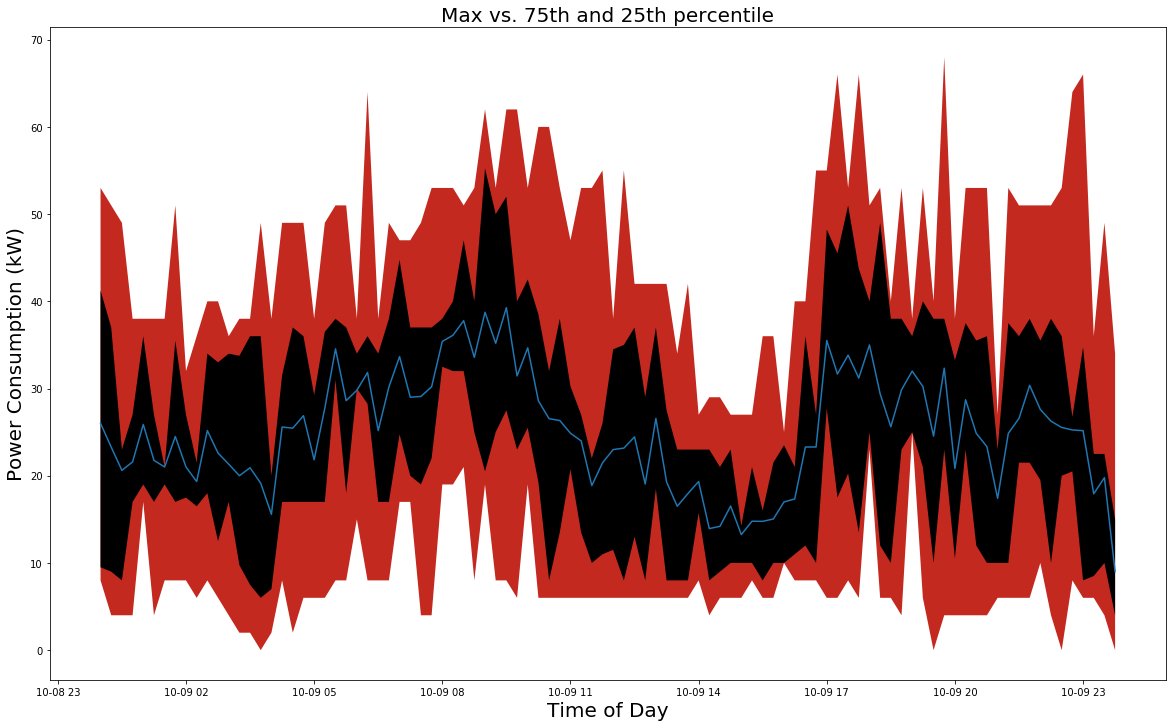

In [918]:
# Plot percentile power consumption data
avg_timeOfPower = get_avg_timeOfPower(timeOfPower)
plt.figure(1, figsize=(20,12))
plt.plot(timeOfDay, avg_timeOfPower)
plt.fill_between(timeOfDay, [max(timeOfPower[i]) for i in range(96)], [min(timeOfPower[i]) for i in range(96)], facecolor='#C4291F')
plt.fill_between(timeOfDay, [np.percentile(timeOfPower[i], 75) for i in range(96)], [np.percentile(timeOfPower[i], 25) for i in range(96)], facecolor='black')
plt.xlabel("Time of Day", fontdict={'fontsize':20})
plt.ylabel("Power Consumption (kW)", fontdict={'fontsize':20})
plt.title("Max vs. 75th and 25th percentile", fontdict={'fontsize':20})
plt.show()

### Operation Daily Power Plot - Eight stations

In [1080]:
def plot_operationDailyPower(staObject_list, day_lowerBound_init=8, duration=22, timestamp_init=15, pen=1, save=1, eng=0):
    """
    Plot as titled.
    staObject_list - list with fully constructed station objects
    day_lowerBound - analysis starting from the day
    duration - analysis length of the day
    timestamp - time interval of data
    pen - Boolean with where you want to know about EV penetration
    save - Boolean with whether you want to save figures
    eng - Boolean with whether you want to store the figure with english station name
    """
    timestamp = timestamp_init
    buckets = int(24*60/timestamp) 
    for station in staObject_list:
        occupy_power_sta_list = []
        date_power_sta_list = []
        length_prior_list = []
        month = station.pills[0].ult_data[0][2].month
        day_lowerBound = day_lowerBound_init
        for day in range(duration):
            day_lowerBound += 1
            day_upperBound = day_lowerBound+1
            date_lowerBound = datetime.datetime(2017, 10, day_lowerBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))
            date_upperBound = datetime.datetime(2017, 10, day_upperBound, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=-420, name=None))

            length_prior = check_num_prior(station, date_lowerBound)
            length_prior_list.append(length_prior)
            length_total = check_num_tot(station)

            occupy_power_sta = np.zeros(length_total)
            power_02 = 0
            #ac charger power
            power_ac_03 = 2  #kw
            power_ac_06 = 7  #kw
            #dc charge power
            power_dc_03 = 40 #kw
            power_dc_06 = 15 #kw
            for pill in station.pills:
                for i, data in enumerate(pill.ult_data):
                    if int(data[0]) == 2 and  date_lowerBound < data[2] and date_upperBound > data[2]:
                        occupy_power_sta[i]+=(power_02)
                    elif int(data[0]) == 3 and date_lowerBound < data[2] and date_upperBound > data[2]:
                        if len(pill.power) is 0:
                            occupy_power_sta[i]+=(power_ac_03)
                        else:
                            occupy_power_sta[i]+=(power_dc_03)
                    elif int(data[0]) == 6 and date_lowerBound < data[2] and date_upperBound > data[2]:
                        if len(pill.power) is None:
                            occupy_power_sta[i]+=(power_ac_06)
                        else:
                            occupy_power_sta[i]+=(power_dc_06)
            occupy_power_sta_list.append(occupy_power_sta)
            date_power_sta = [data[2] for data in station.pills[0].ult_data if 
                        date_lowerBound < data[2] and date_upperBound > data[2]]
            date_power_sta_list.append(date_power_sta)
        if len(date_power_sta_list[0]) == 0:
            pass
        else:
            # Map date to same day    
            date_power_sta_list = convert_day(date_power_sta_list)
            timeOfPower = map_powerOfDay(date_power_sta_list, occupy_power_sta_list, length_prior_list, timestamp)
            timeOfDay = create_timeOfDay(date_power_sta_list, timestamp)

            #Calculte EV penetration
            avg_timeOfPower = get_avg_timeOfPower(timeOfPower, timestamp)
            penetration = np.divide(avg_timeOfPower, station.get_maxPower())*100 #percentage
            #Plot percentile power consumption data
            if pen:
                fig, ax1 = plt.subplots(figsize=(20,12))
                ax2 = ax1.twinx()
                ax1.plot(timeOfDay, avg_timeOfPower, label="Average Power Consumption (kW)", color="blue")
                ax1.fill_between(timeOfDay, [max(timeOfPower[i]) for i in range(buckets)], [min(timeOfPower[i]) for i in range(buckets)], facecolor='#C4291F')
                ax1.fill_between(timeOfDay, [np.percentile(timeOfPower[i], 75) for i in range(buckets)], [np.percentile(timeOfPower[i], 25) for i in range(buckets)], facecolor='black')
                ax1.set_xlabel("Time of Day", fontdict={'fontsize':20})
                ax1.set_ylabel("Power Consumption (kW)", fontdict={'fontsize':20})
                ax1.set_ybound(lower=0)

                ax2.plot(timeOfDay, penetration, label="EV penetration rate (%)", color="#c1a481")
                ax2.set_ylabel("EV Penetration (%)", fontdict={'fontsize':20})
                ax2.set_ybound(0, max(penetration)+10)

                ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
                ax2.legend(loc='upper right', bbox_to_anchor=(0.8, 1))
                ax1.set_title("Max vs. 75th and 25th percentile + EV Penetration", fontdict={'fontsize':20})
                if save:
                    if eng:
                        plt.savefig("{}+Penetration.png".format(station.get_stationName_Eng()))
                    else:
                        plt.savefig(station.name+"+penetration")
            else:
                plt.figure(1, figsize=(20,12))
                plt.plot(timeOfDay, avg_timeOfPower, label="Average Power Consumption (kW)")
                plt.fill_between(timeOfDay, [max(timeOfPower[i]) for i in range(buckets)], [min(timeOfPower[i]) for i in range(buckets)], facecolor='#C4291F')
                plt.fill_between(timeOfDay, [np.percentile(timeOfPower[i], 75) for i in range(buckets)], [np.percentile(timeOfPower[i], 25) for i in range(buckets)], facecolor='black')
                plt.xlabel("Time of Day", fontdict={'fontsize':20})
                plt.ylabel("Power Consumption (kW)", fontdict={'fontsize':20})
                plt.ylim(ymin=0)
                plt.title("Max vs. 75th and 25th percentile", fontdict={'fontsize':20})
                plt.legend()
                if save:
                    if eng:
                        plt.savefig("{}.png".format(station.get_stationName_Eng()))
                    else:
                        plt.savefig(station.name)

            print(station.name, station.get_stationName_Eng())
            plt.show()

Querying from server
Initializing..
Constructing..
Updating..
深圳银星工业园充电站
[<__main__.Pill object at 0x1164b9208>, <__main__.Pill object at 0x1164b9048>, <__main__.Pill object at 0x1164b9128>, <__main__.Pill object at 0x1164b9f60>, <__main__.Pill object at 0x1164b9cf8>, <__main__.Pill object at 0x1164b9860>, <__main__.Pill object at 0x116473f60>, <__main__.Pill object at 0x116473470>, <__main__.Pill object at 0x1163e5358>, <__main__.Pill object at 0x1163e55c0>, <__main__.Pill object at 0x1163e54a8>, <__main__.Pill object at 0x1164da7f0>, <__main__.Pill object at 0x1164daac8>, <__main__.Pill object at 0x1164daa90>, <__main__.Pill object at 0x1164da9b0>, <__main__.Pill object at 0x1164dab70>, <__main__.Pill object at 0x1164da4e0>, <__main__.Pill object at 0x1164da8d0>, <__main__.Pill object at 0x1164da6d8>]
Let's make a plot
北京航空精密机械研究所充电站 Beijing Aviation Precision Machinery Research Institute charging station


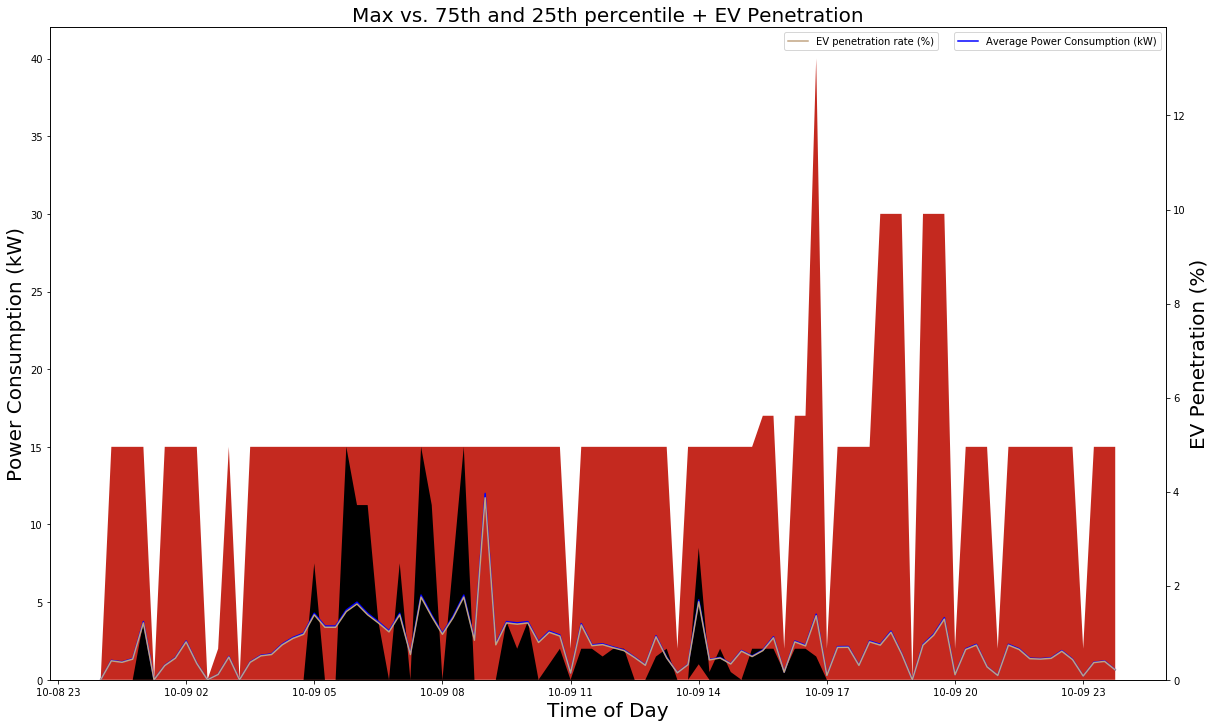

北京西郊宾馆充电站 Beijing Xijiao Hotel charging station


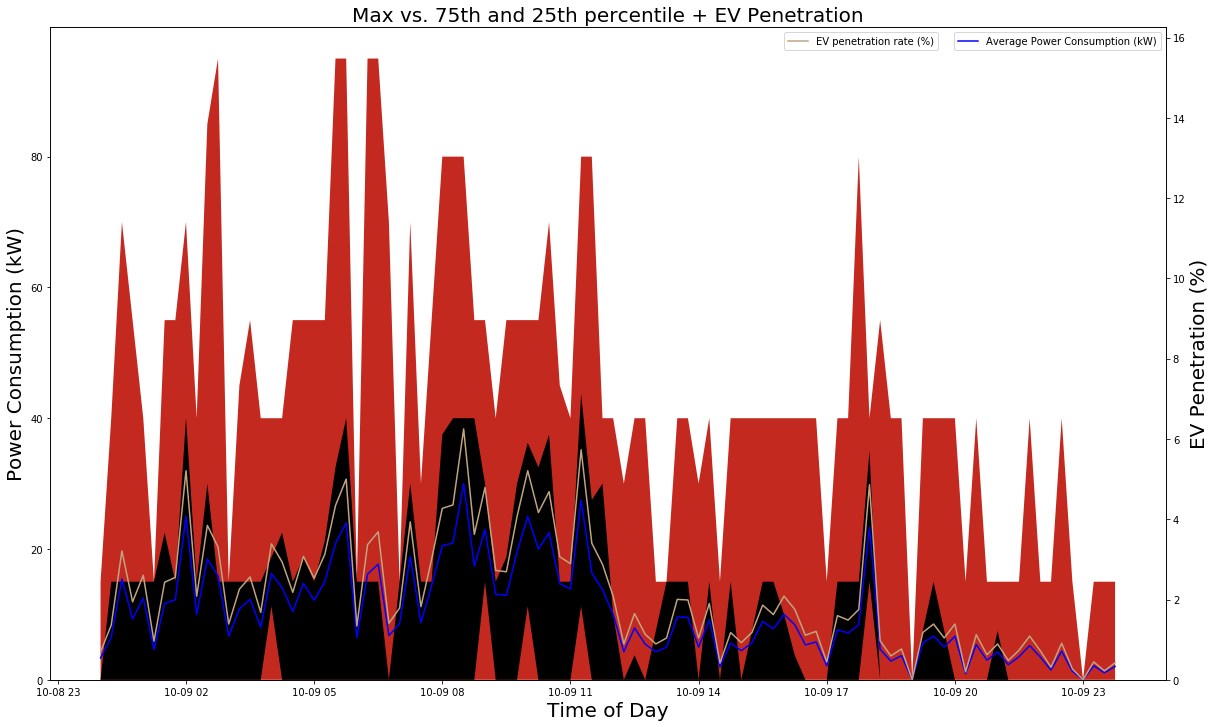

北京阳光丽城酒店充电站 Beijing Sunshine Belvedere Hotel charging station


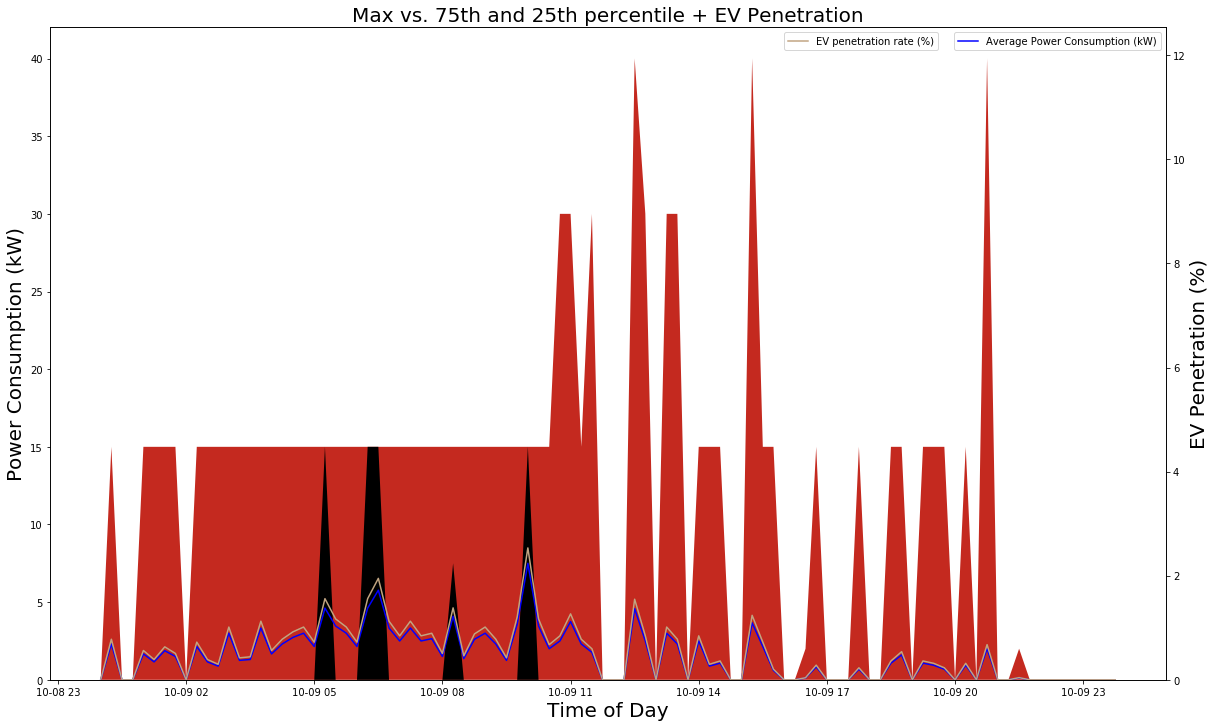

北京元亨苑林山庄有限公司充电站 Beijing Yuanhengyuan Lin Villa Co., Ltd. charging station


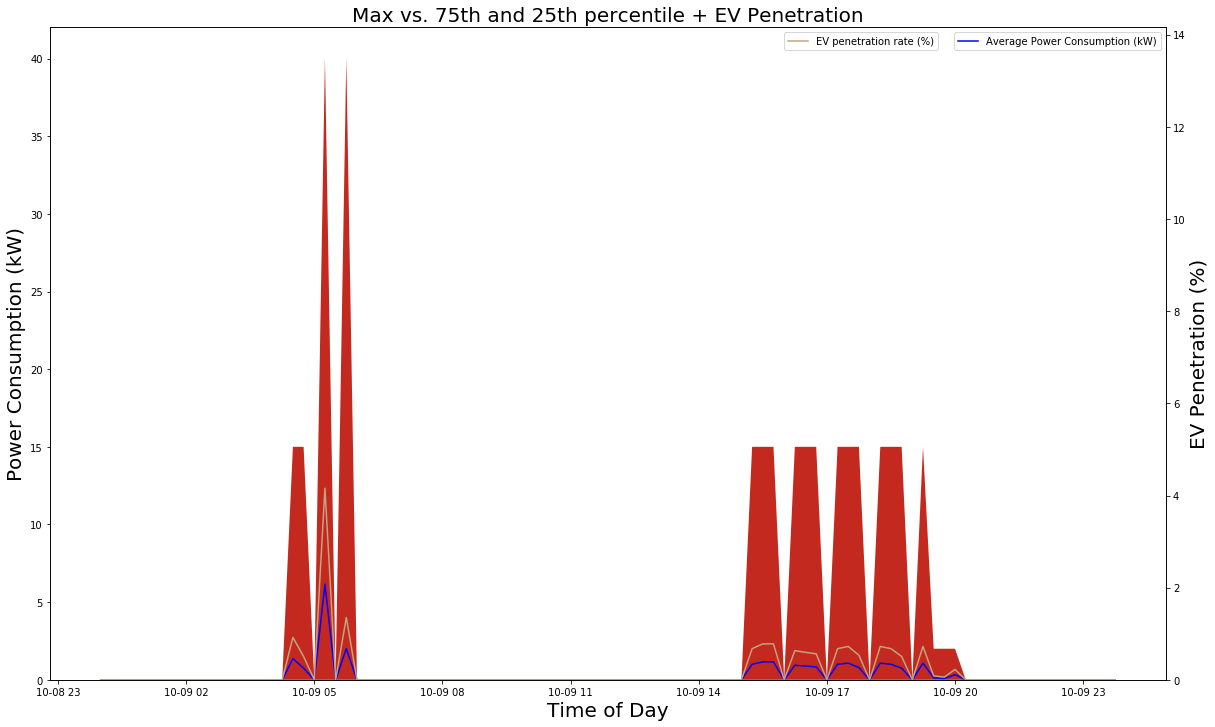

深圳恒江大厦充电站 Shenzhen Hengjiang Building Charging Station


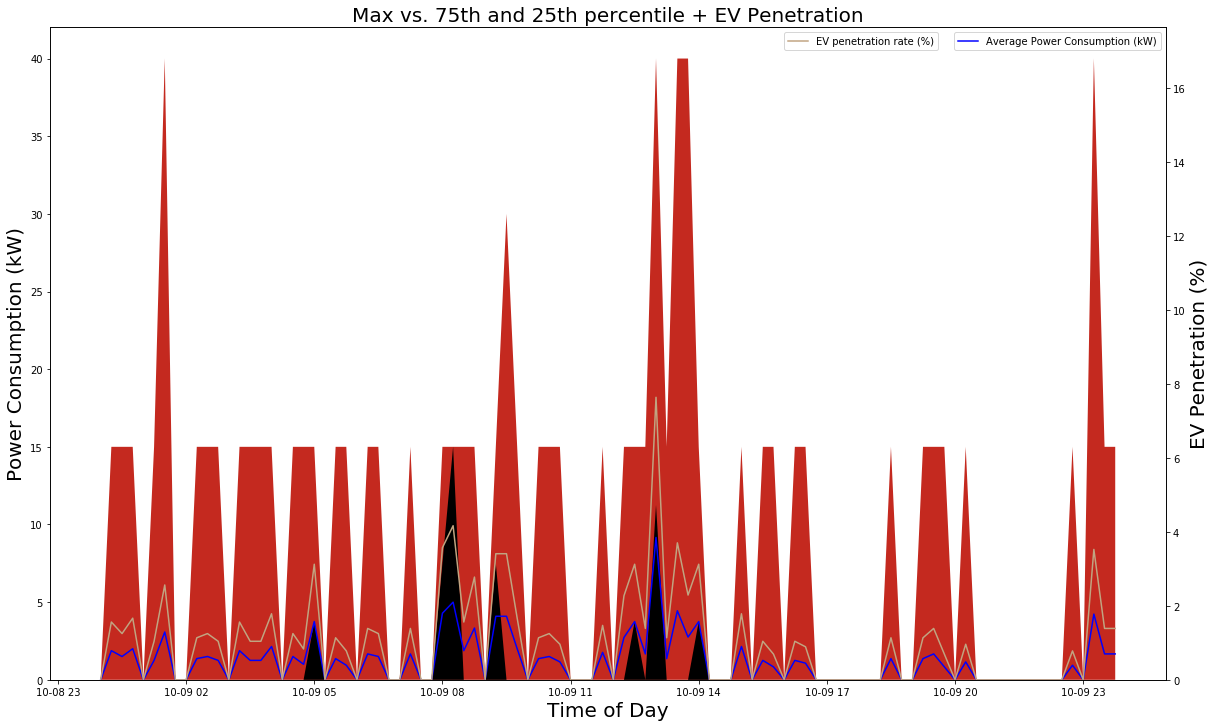

深圳银星工业园充电站 Shenzhen Silver Star Industrial Park Charging Station


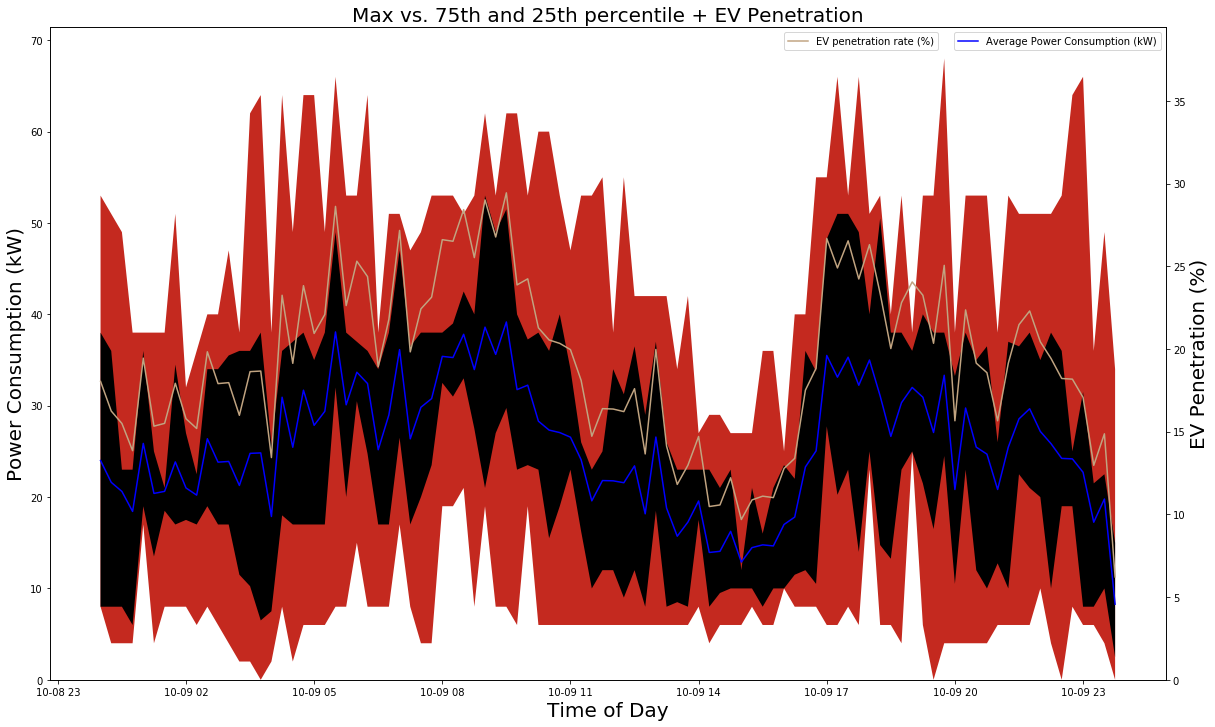

深圳万科九龙山充电站 Shenzhen Vanke Jiulongshan Charging Station


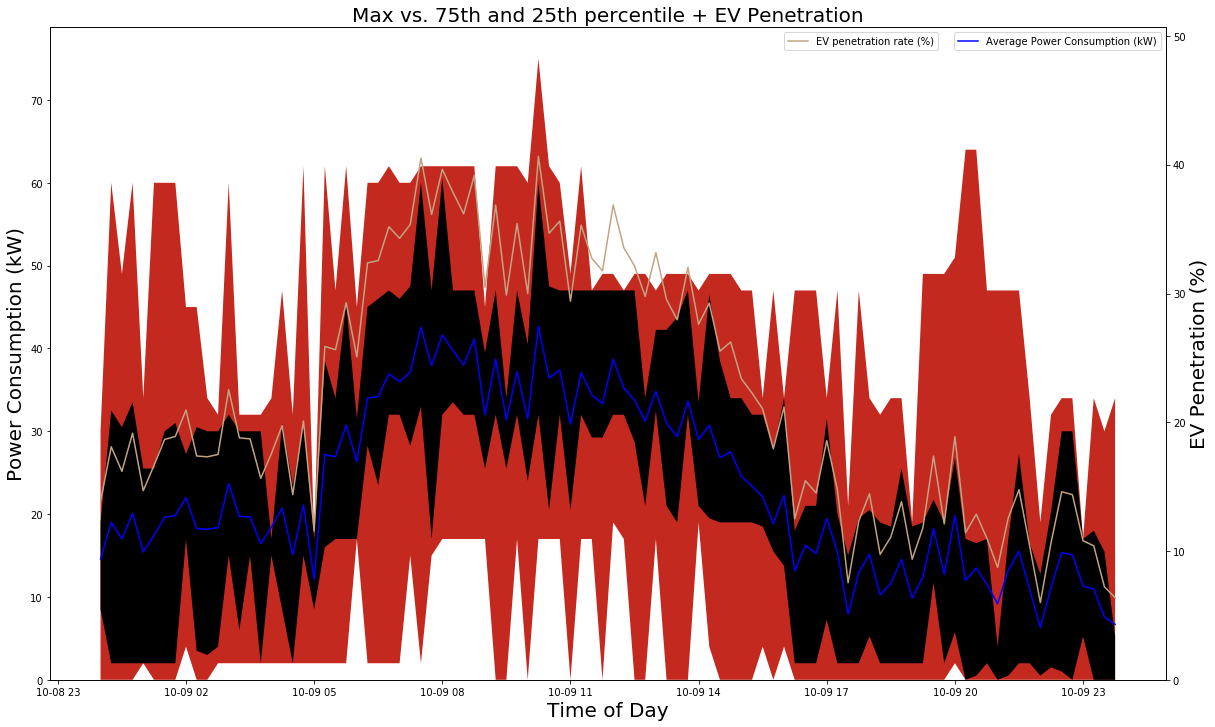

深圳景元大厦充电站 Shenzhen Jing Yuan Building Charging Station


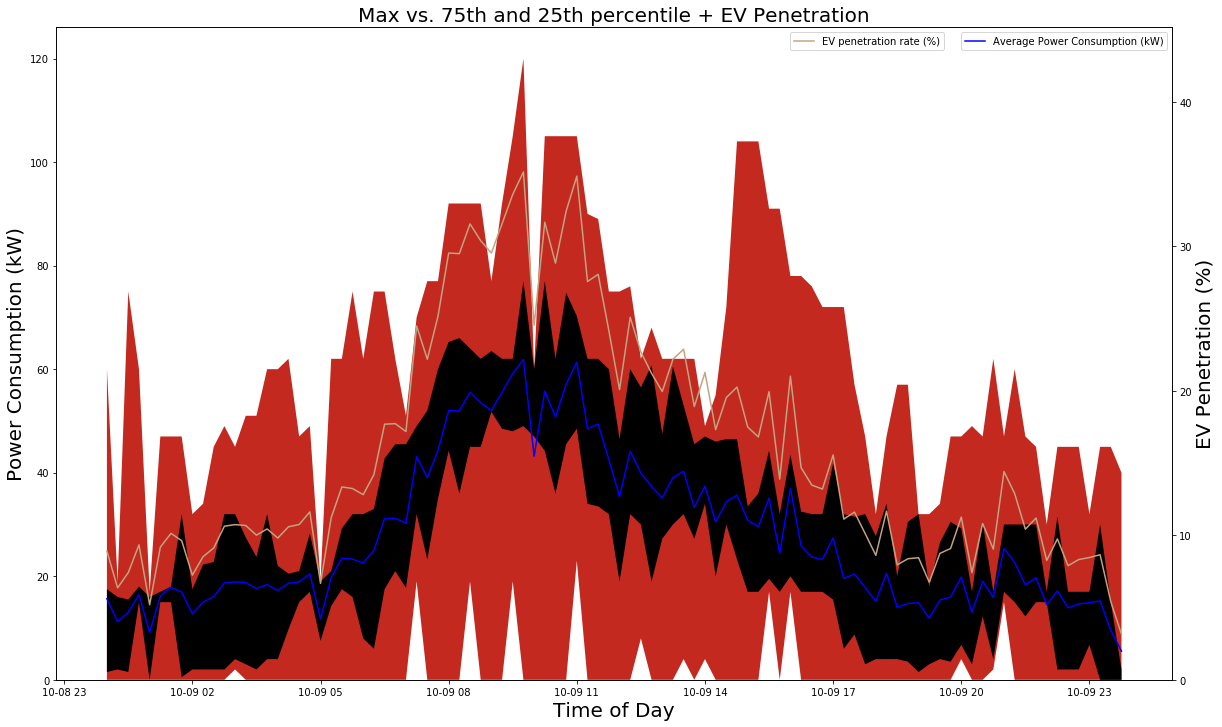

In [1086]:
# plot_operationDailyPower(staObject_list)
plt.close()
main(sta_list, timestamp_init=15, day_lowerBound_init=8, duration=22,pen=1, save=0, eng=0)

# Main

In [1089]:
def main(sta_list, timestamp_init=30, day_lowerBound_init=19, duration=10, pen=1, save=0, eng=0):
    #Request data from server
    print("Querying from server")
    pillcode_list, pill_details_list, sta_details_list = get_pill_station_details(sta_list)
    #Initialize station objects
    print("Initializing..")
    staObject_list = init_station_obj(sta_list, sta_details_list)
    #Construct full station objects
    print("Constructing..")
    staObject_list = constr_station_objFull(staObject_list, pillcode_list)
    #Update utilization data to pills of stations
    print("Updating..")
    staObject_list = update_daily_ultData(staObject_list)
    #Data visualization
    print("Let's make a plot")
    plot_operationDailyPower(staObject_list, day_lowerBound_init, duration, timestamp_init, pen, save, eng)

In [1085]:
db_name="db_teld"
user_name="postgres"
password = "postgres"
host="169.229.157.40"
port="5432"
conn = indb.init_db(db_name, user_name, password, host, port)

Querying from server
Initializing..
Constructing..
Updating..
Let's make a plot
深圳水木丹华充电站 Shenzhen Shuimu Danhua charging station


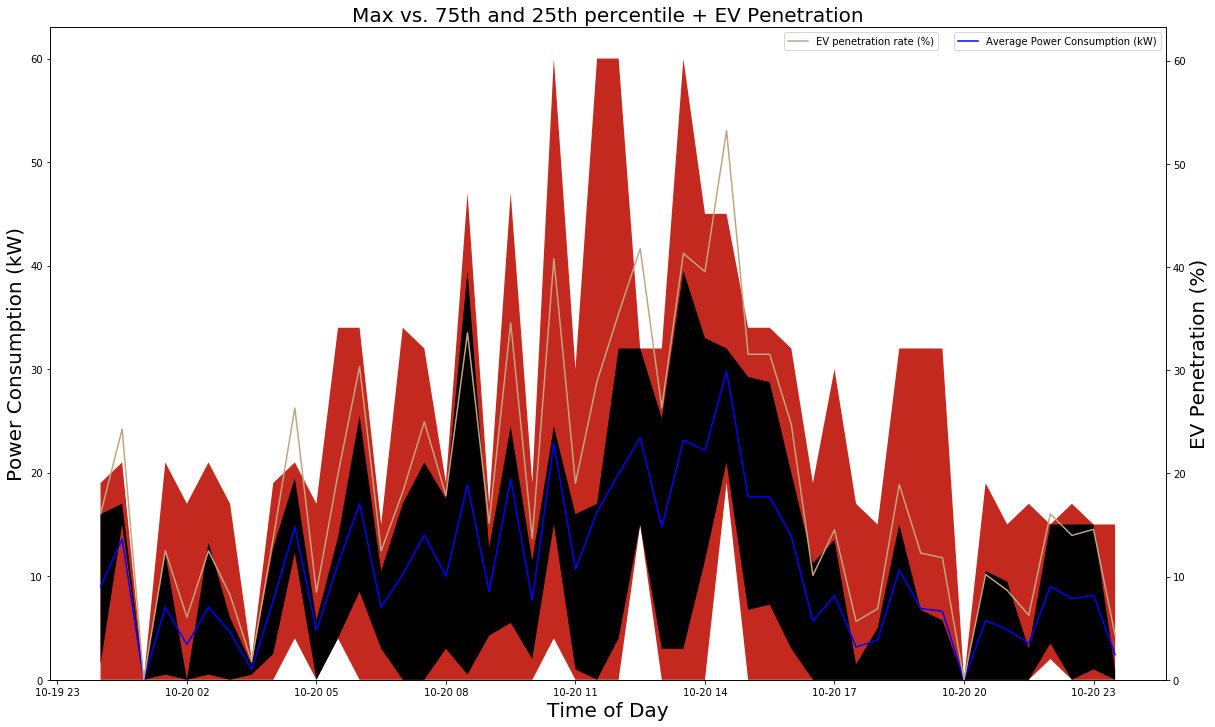

深圳天安国际大厦充电站 Shenzhen Tian An International Building Charging Station


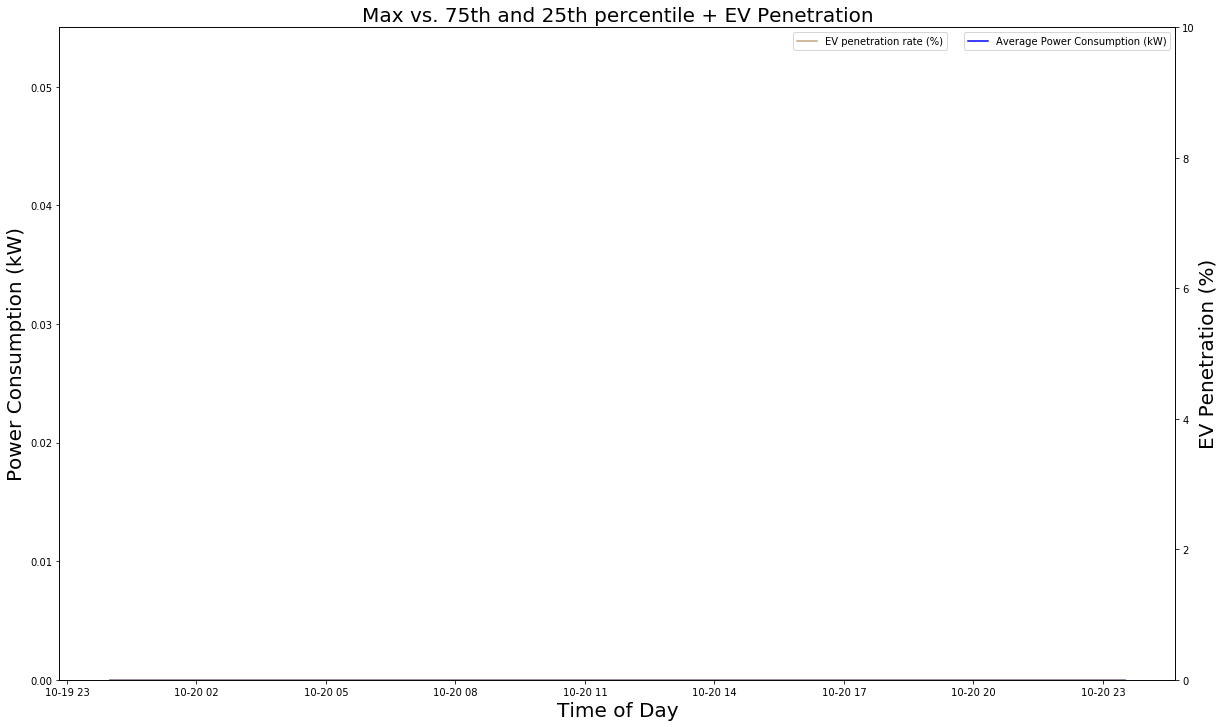

深圳联泰大厦充电站 Shenzhen Luen Thai Building Charging Station


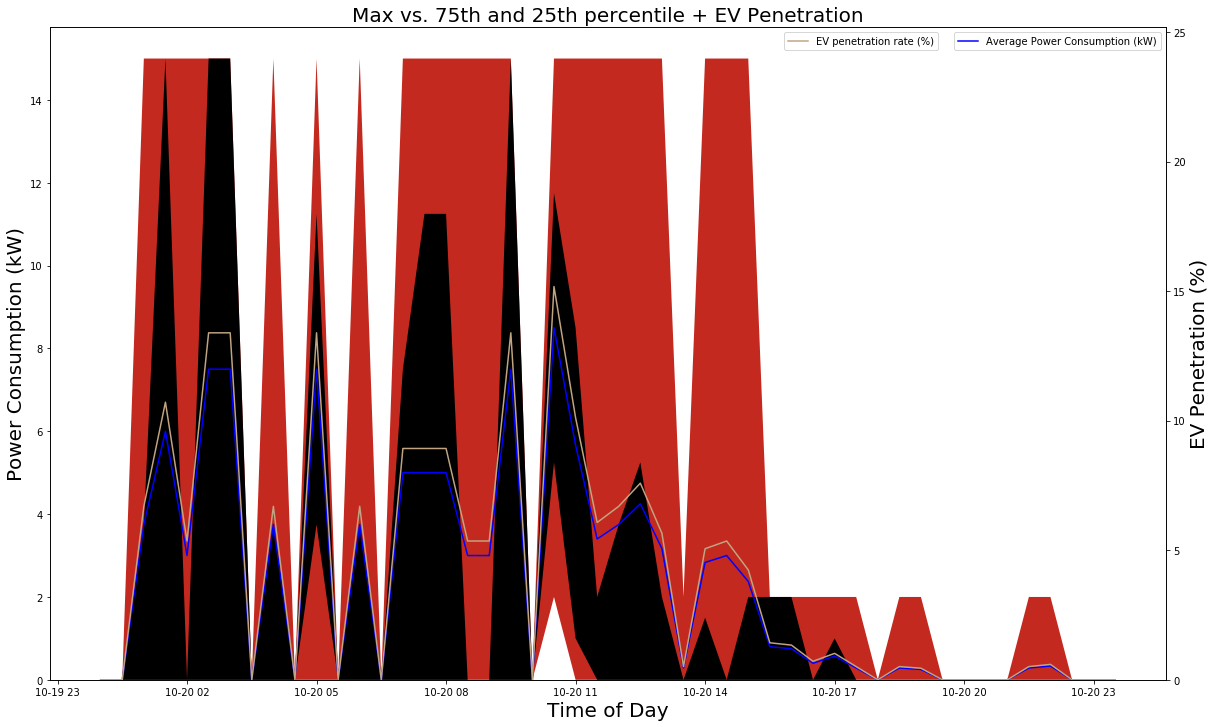

深圳南山书城充电站 Shenzhen Nanshan Bookstore Charging Station


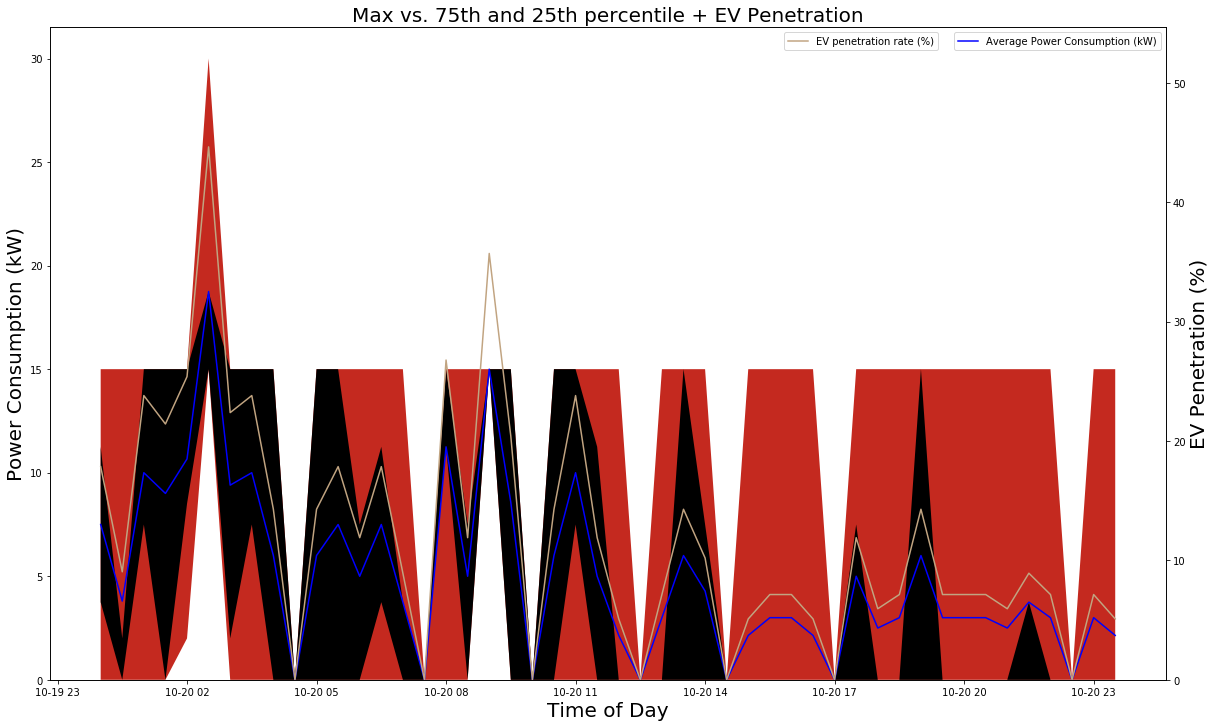

深圳园博园管理处充电站 Shenzhen Park Park Management Office charging station


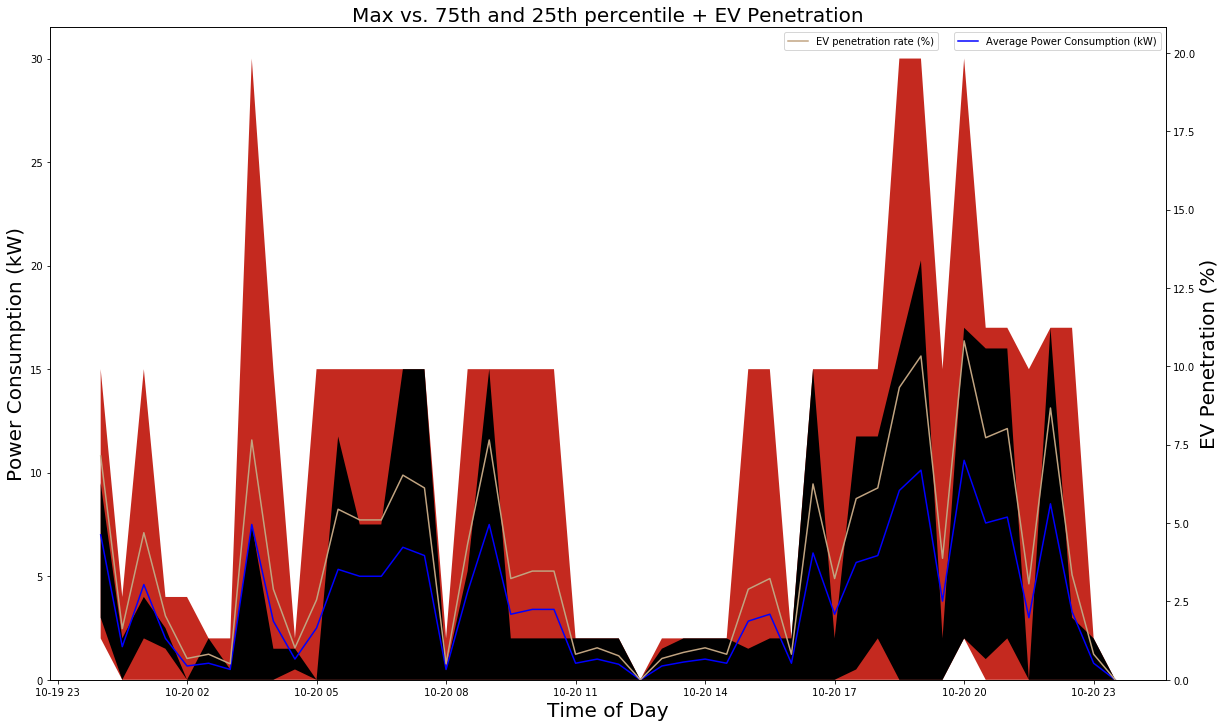

深圳京基晶都酒店充电站 Shenzhen Jingji Jingdu Hotel charging station


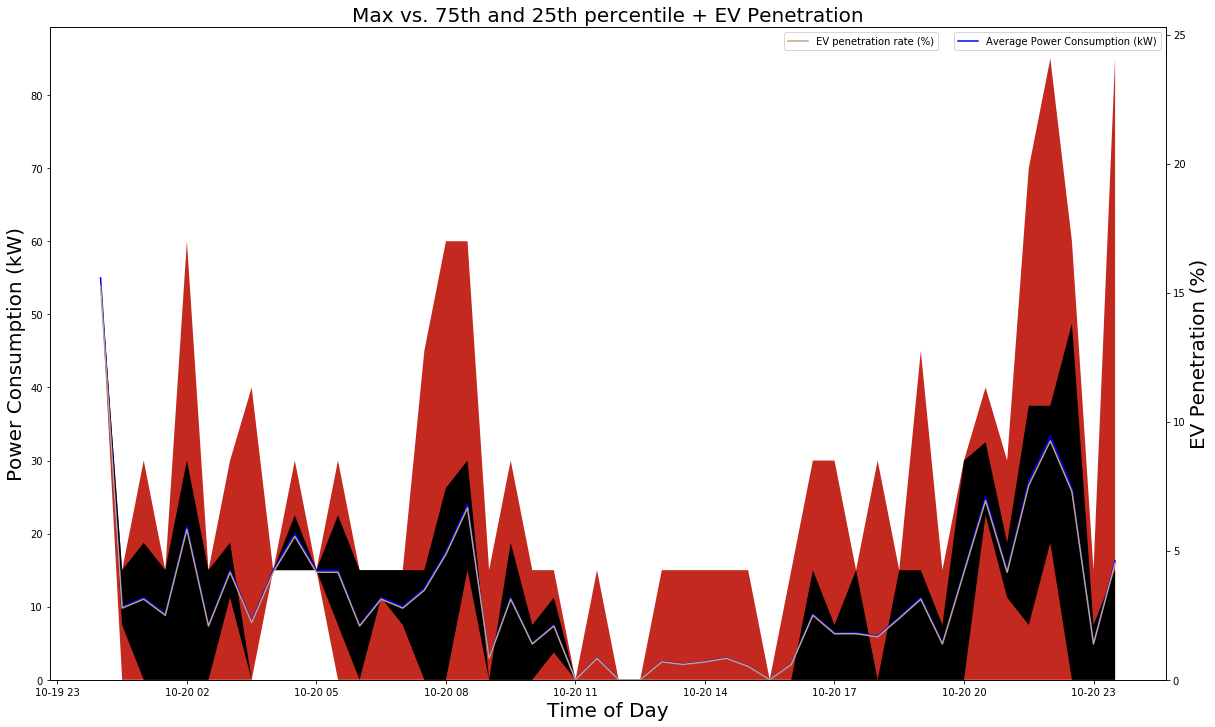

深圳书城中心城充电站 Shenzhen Book City Center City Charging Station


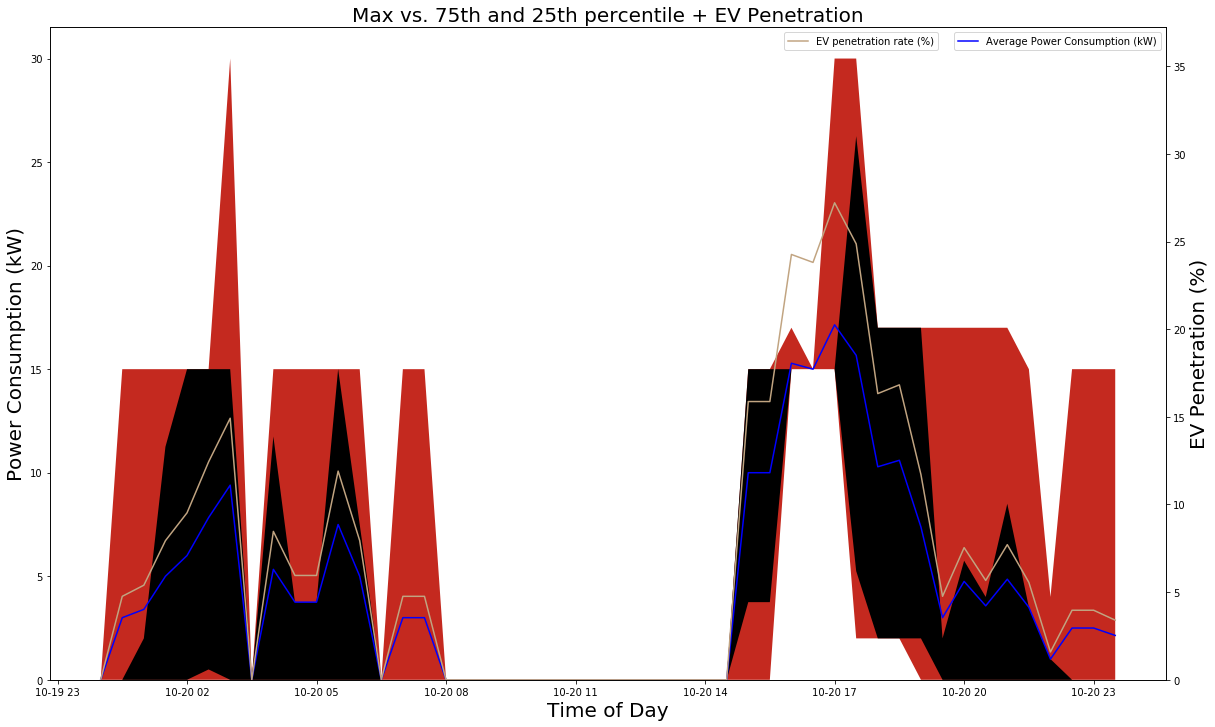

深圳大冲都市花园充电站 Shenzhen Daping City Garden Charging Station


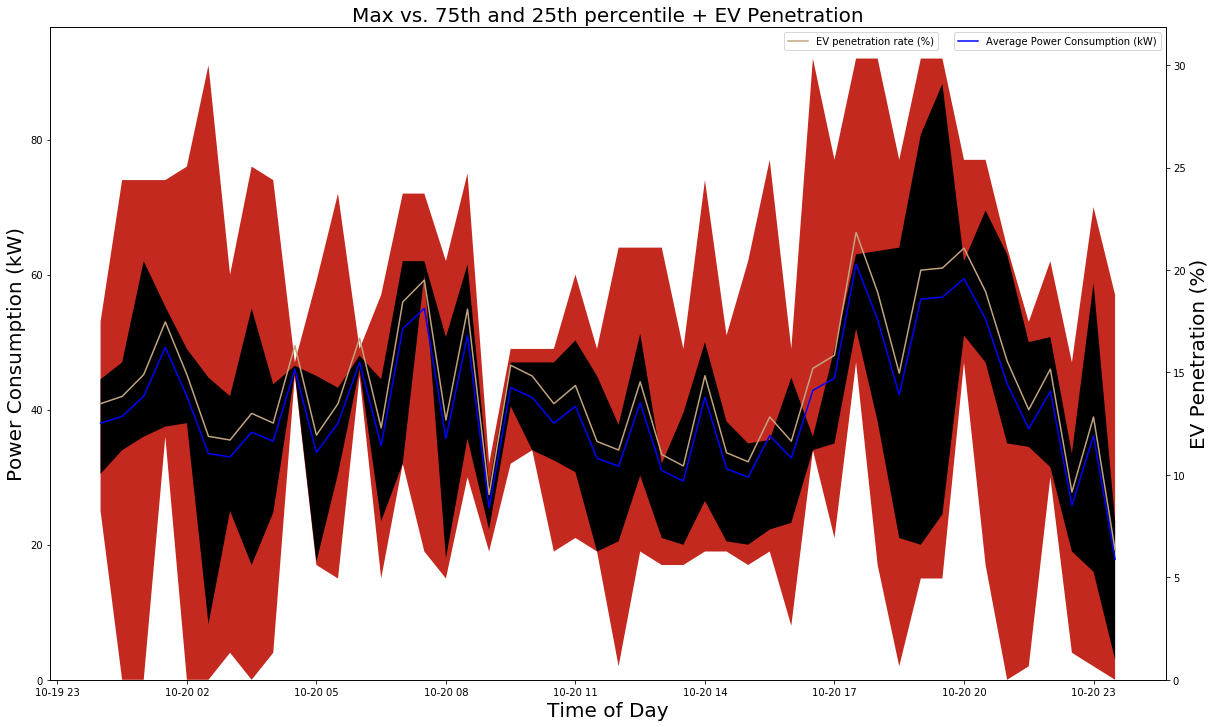

深圳创维半导体大厦充电站 Shenzhen Skyworth Semiconductor Building Charging Station


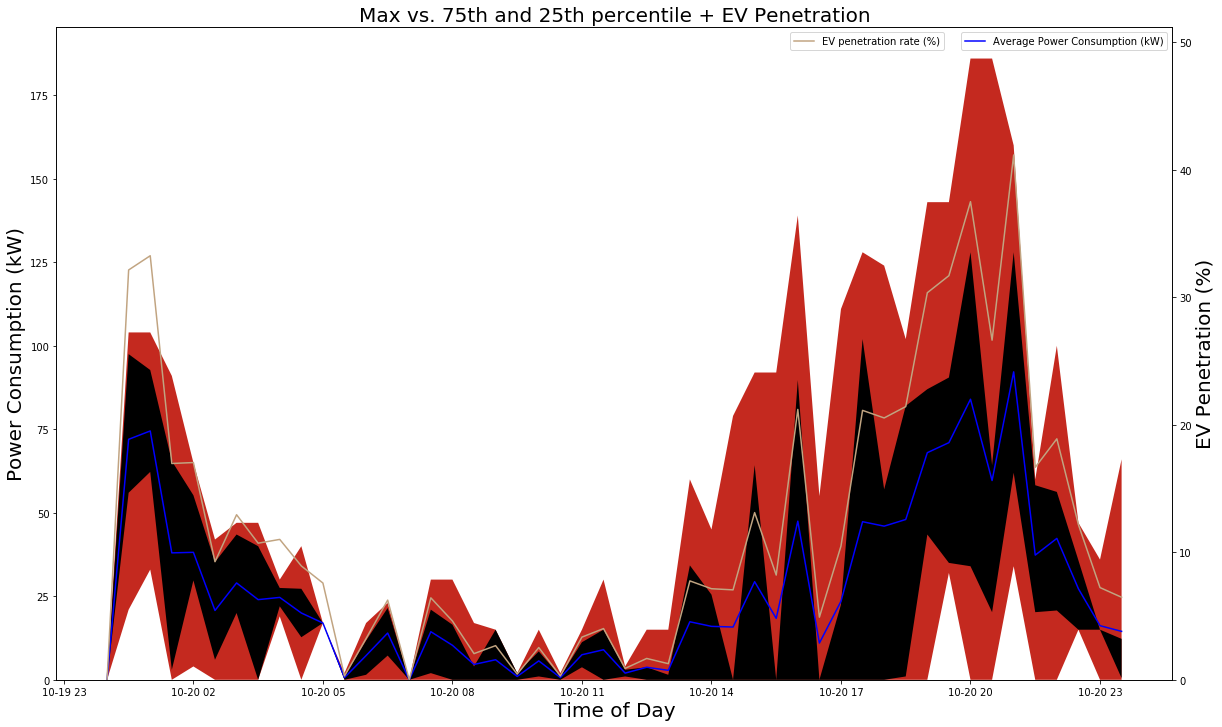

深圳天发大厦充电站 Shenzhen Tianfa Building Charging Station


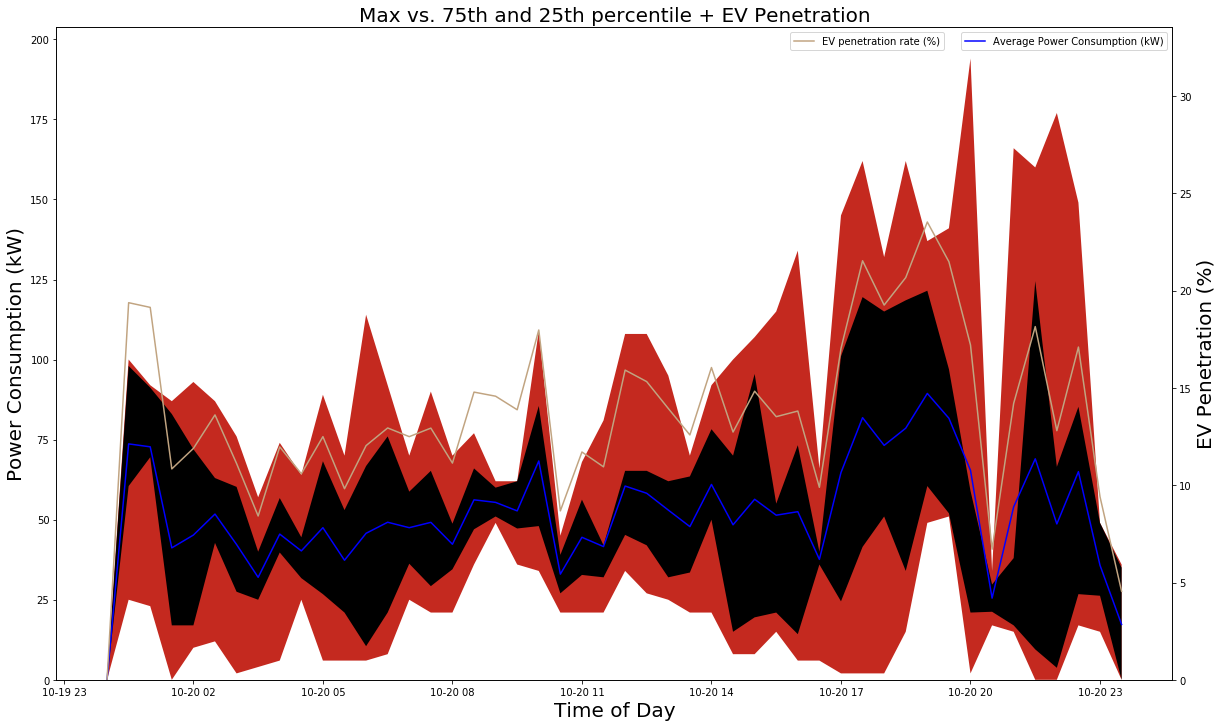

深圳豪方花园充电站 Shenzhen Hao Fang Garden charging station


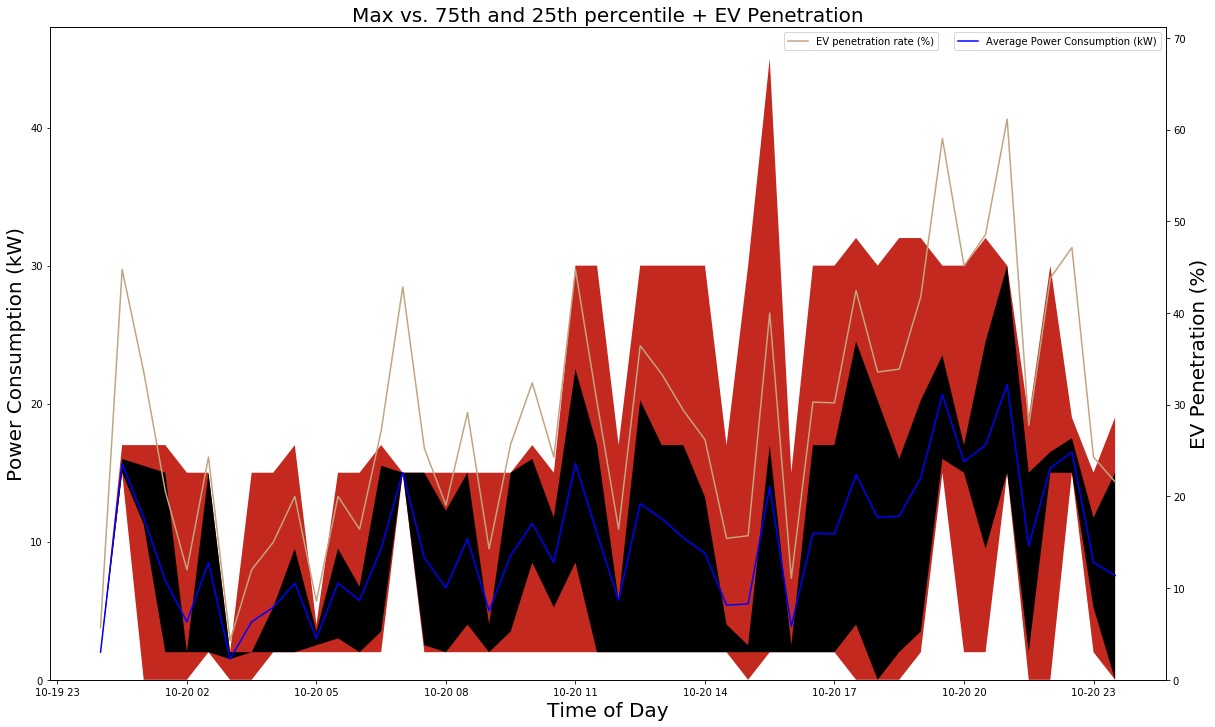

深圳军威物业充电站 Shenzhen Junwei property charging station


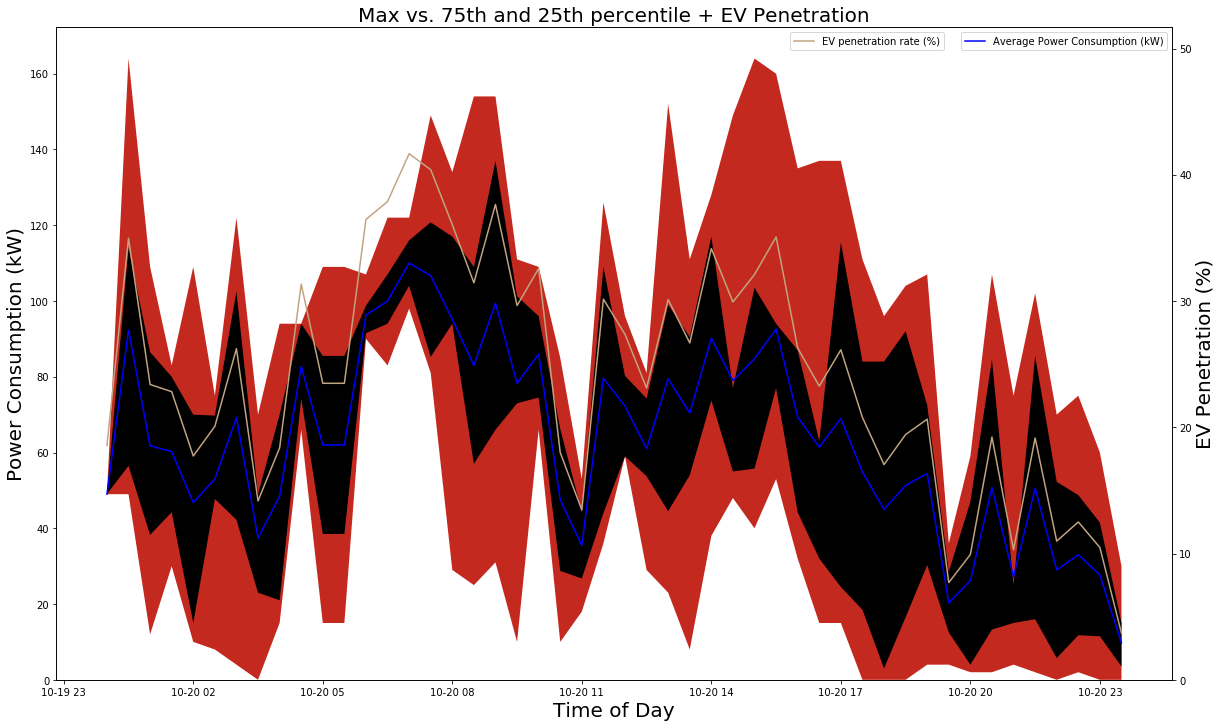

深圳熙璟城充电站 Shenzhen Xi Jing City charging station


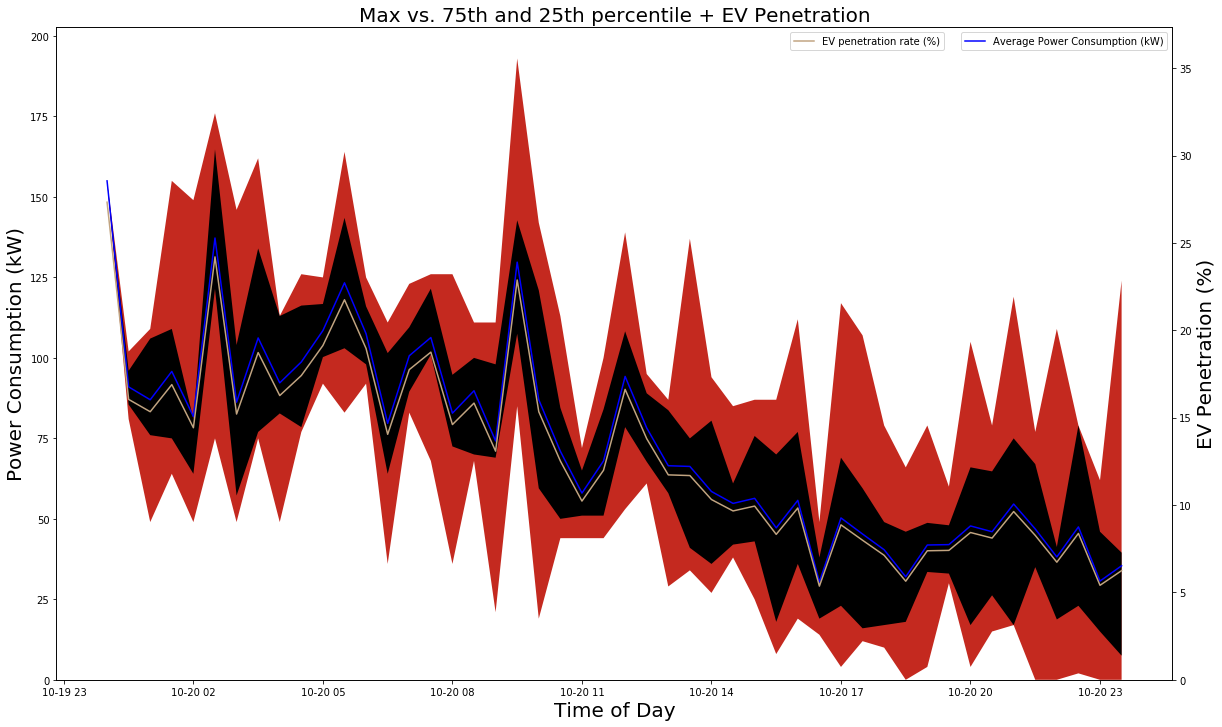

深圳凤凰大厦充电站 Shenzhen Phoenix Building Charging Station


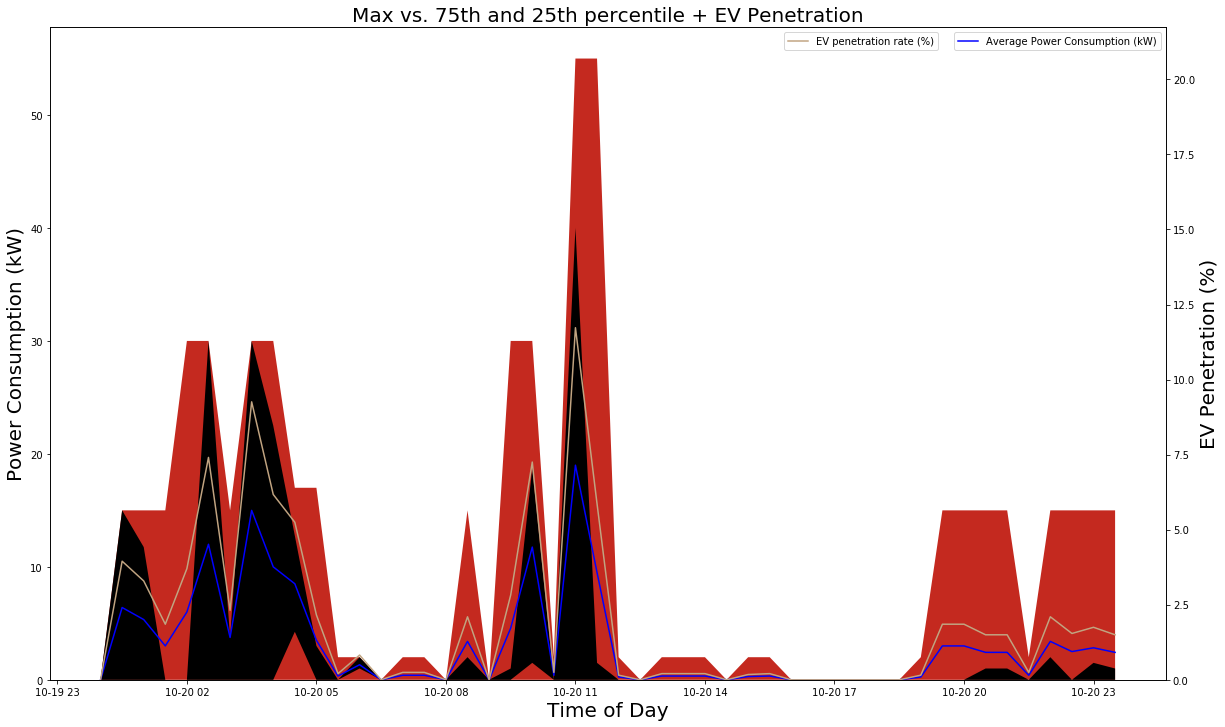

深圳公园一号广场充电站 Shenzhen Park on the 1st square charging station


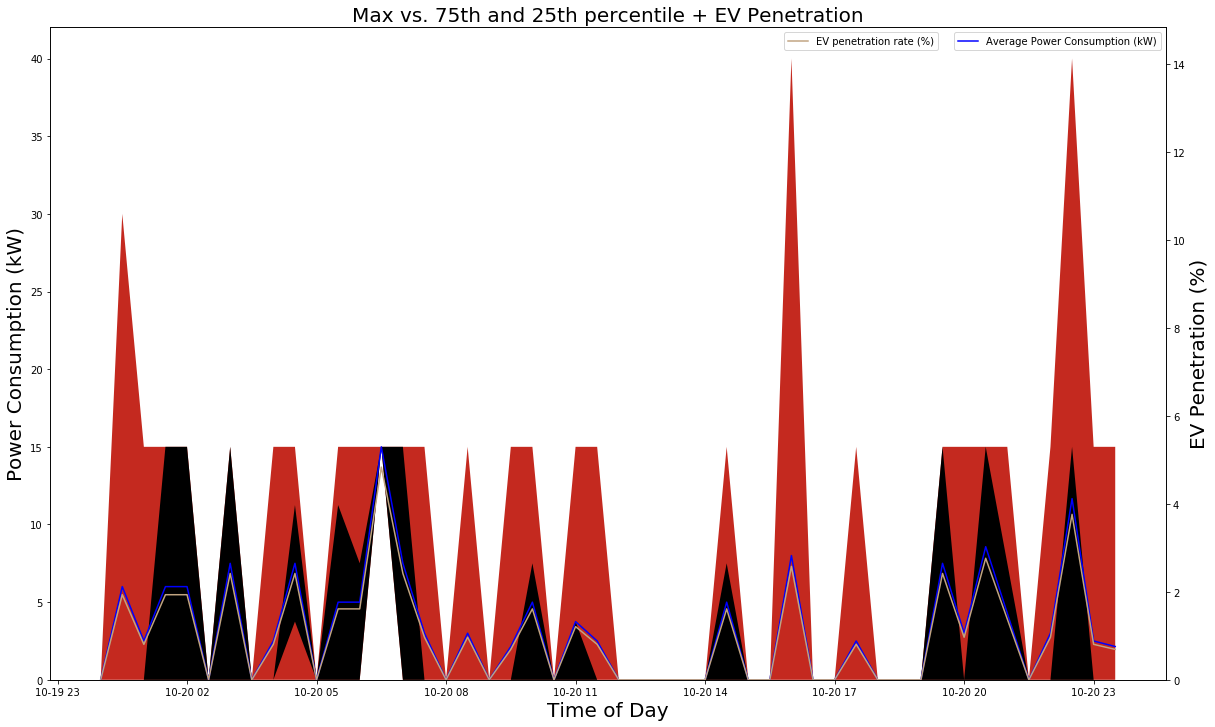

深圳长富金茂大厦充电站 Shenzhen Chang Fu Jin Mao Building Charging Station


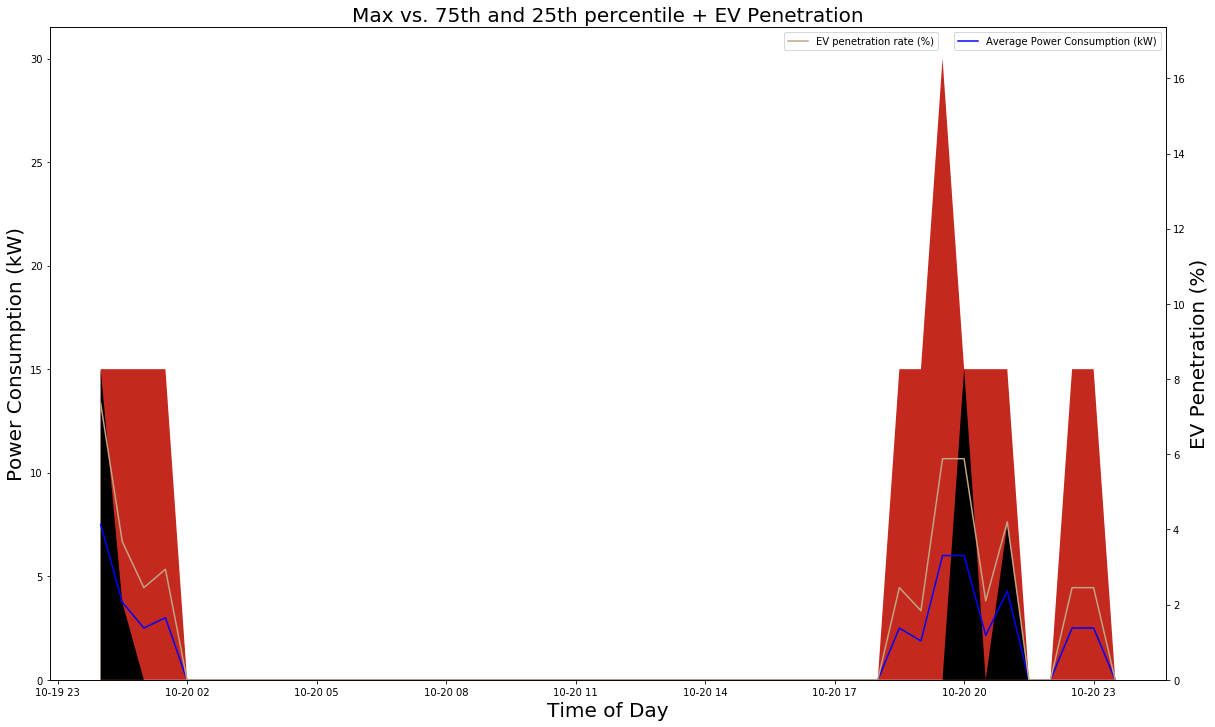

深圳李朗珠宝产业园充电站 Shenzhen Li Lang Jewelry Industrial Park Charging Station


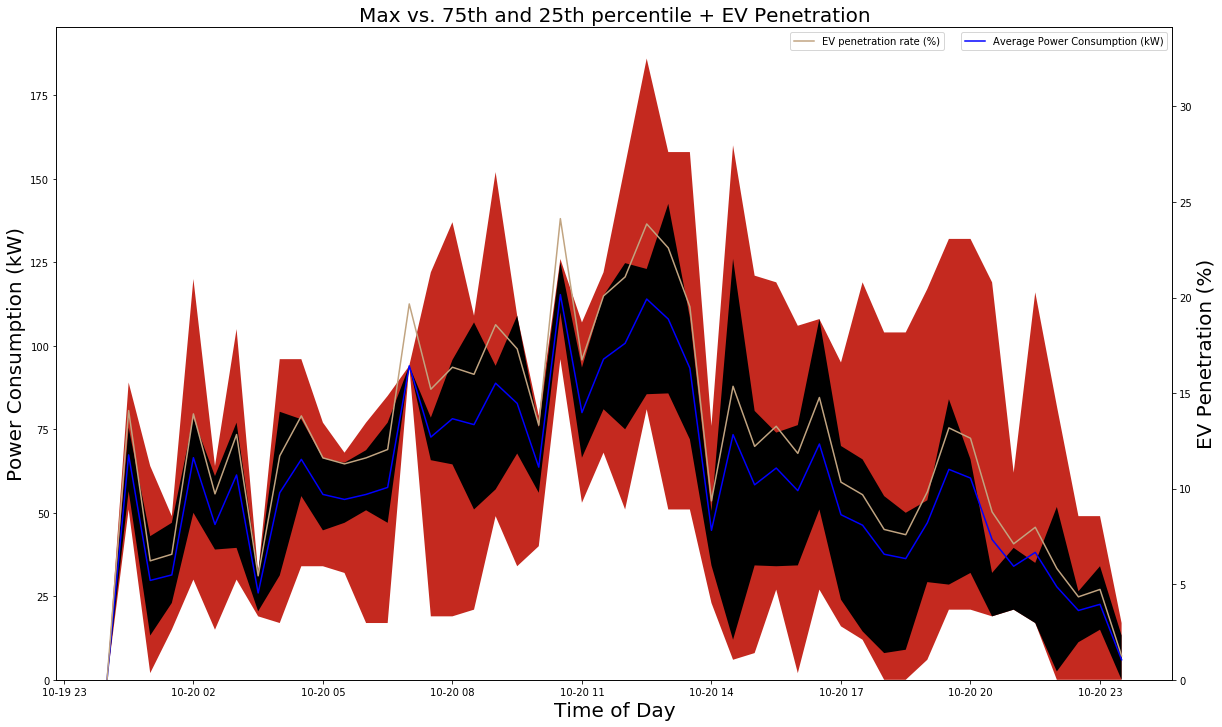

深圳华晖云门充电站 Shenzhen Huahui Cloud Gate Charging Station


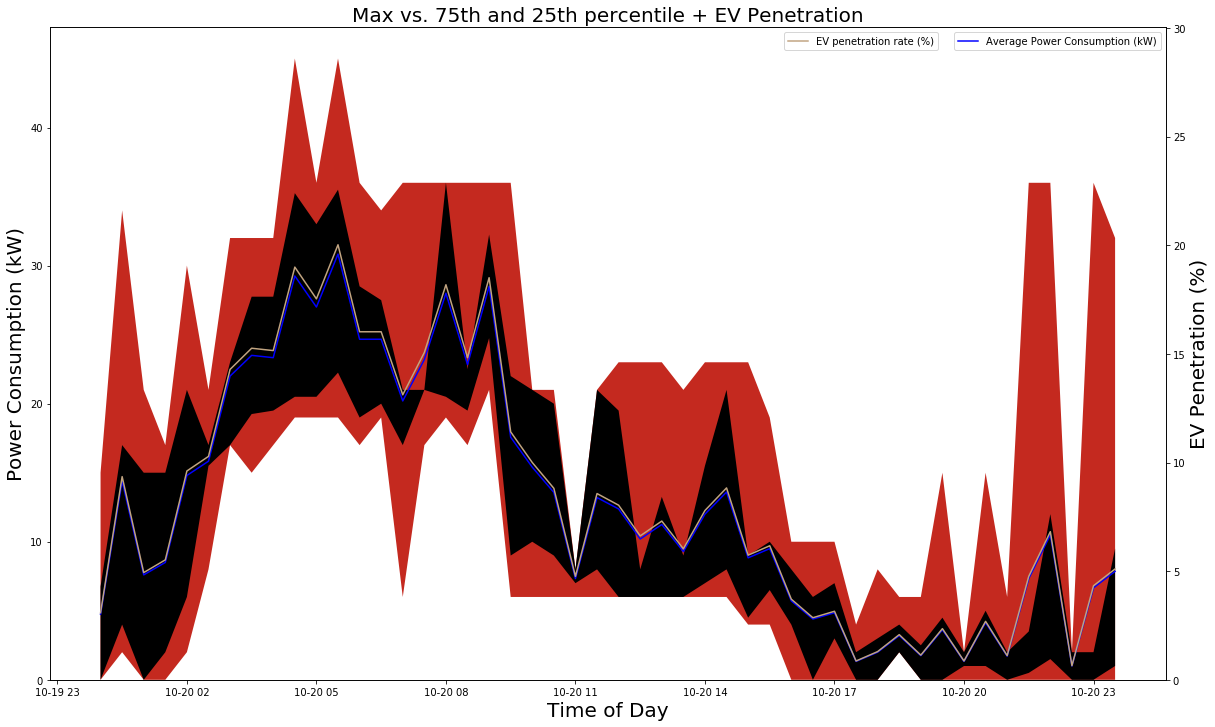

深圳创维大厦充电站 Shenzhen Skyworth Building Charging Station


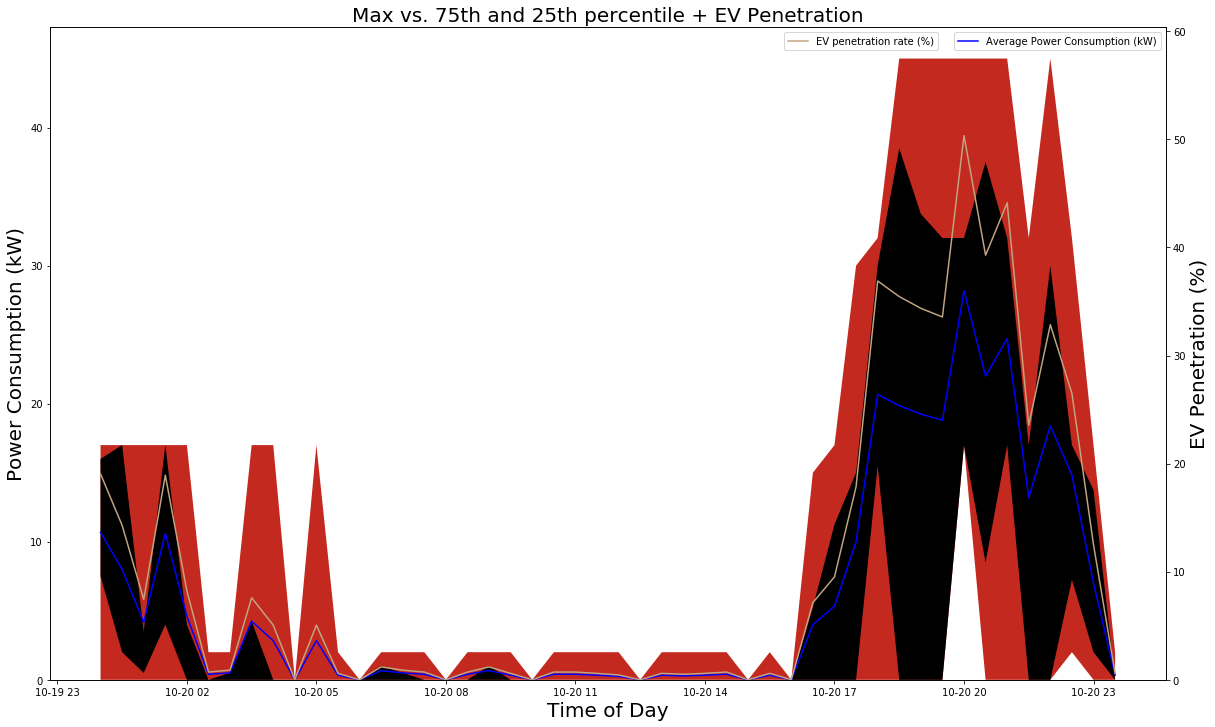

深圳百丽大厦充电站 Shenzhen Belle Building Charging Station


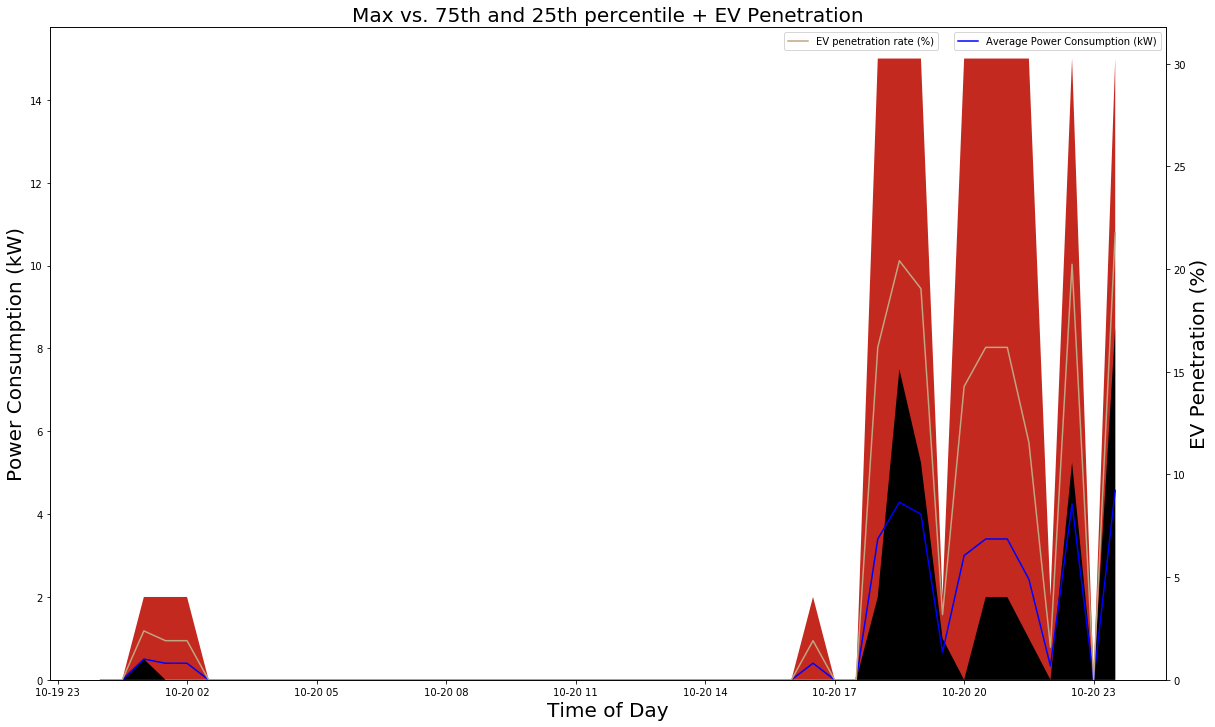

深圳星都豪庭充电站 Shenzhen Star are ho charge station


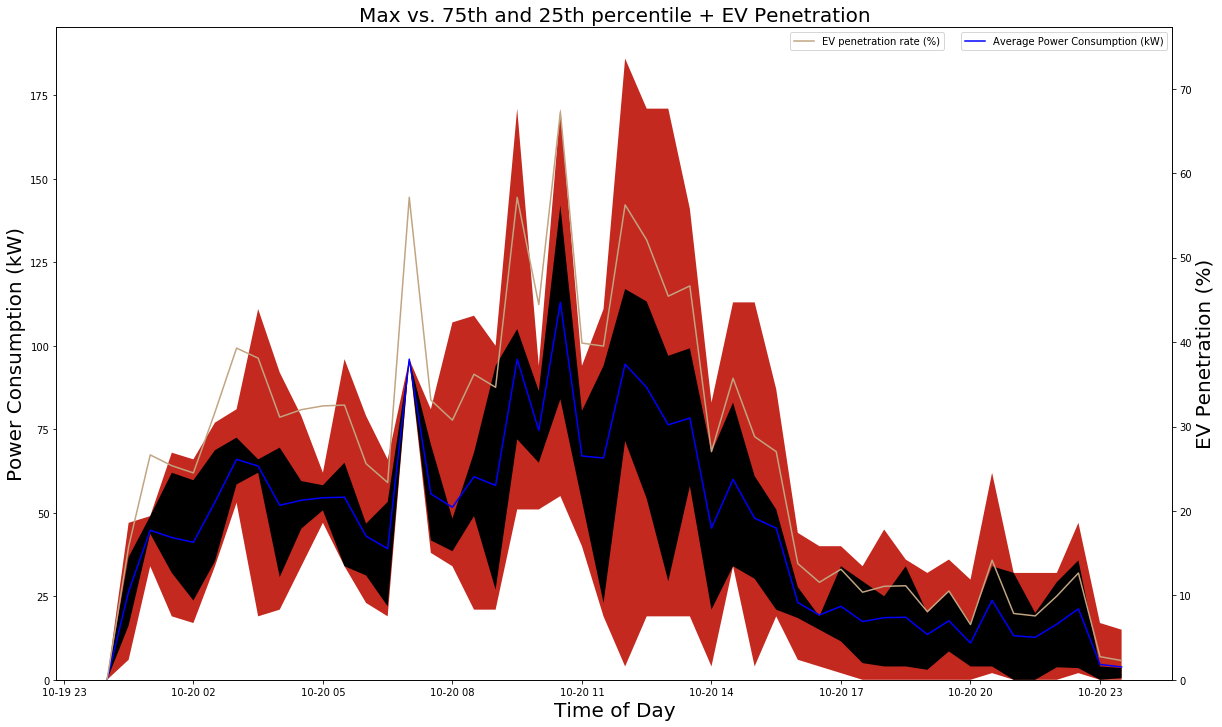

深圳南景新村充电站 Shenzhen South King Village Charging Station


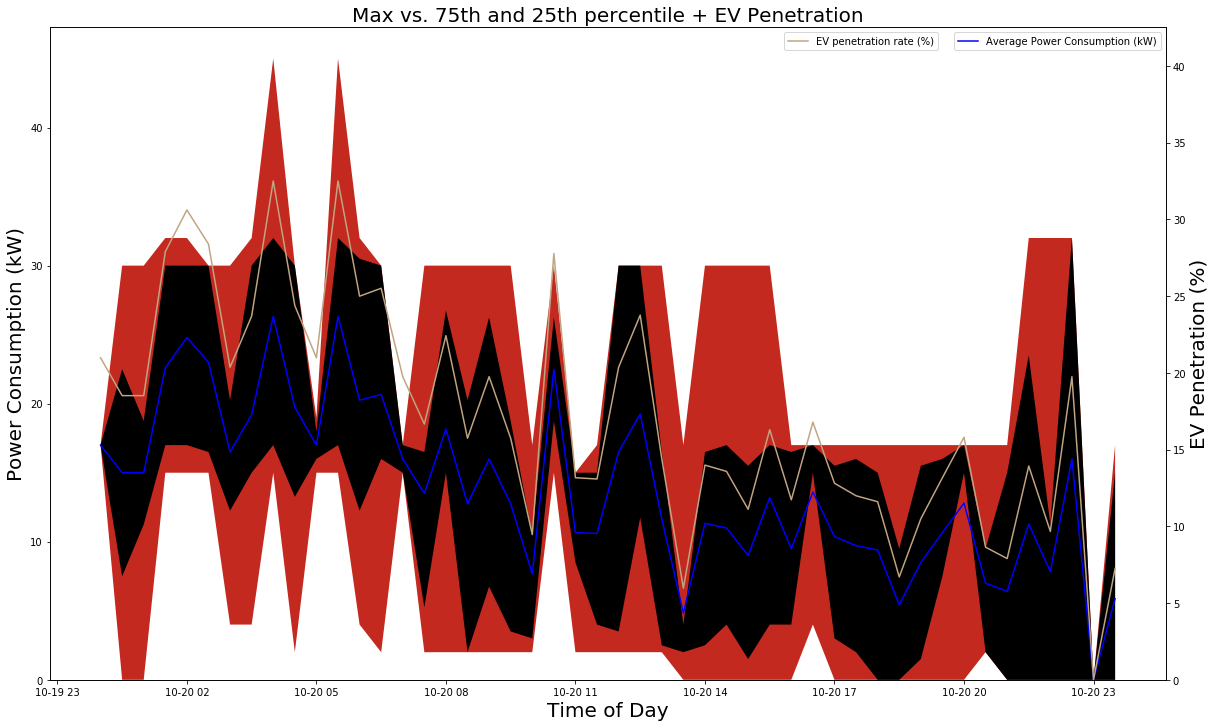

深圳龙华人人乐充电站 Shenzhen Longhua everyone music charging station


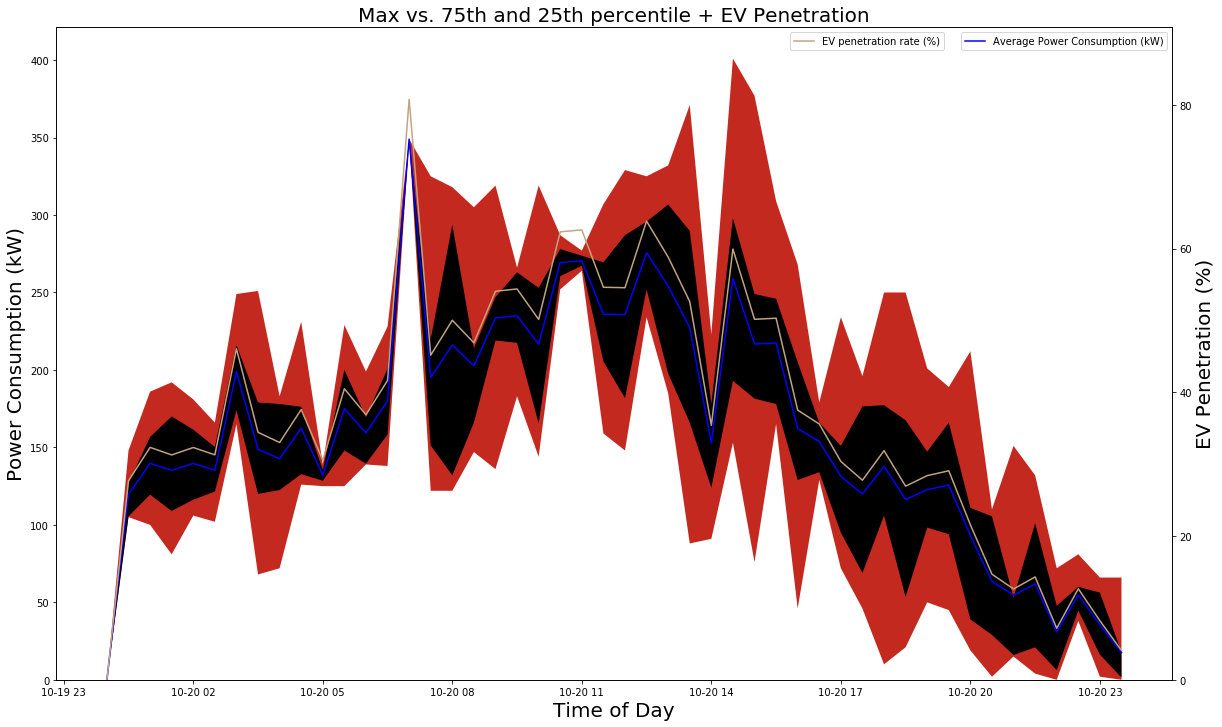

深圳深业U中心充电站 Shenzhen deep industry U center charging station


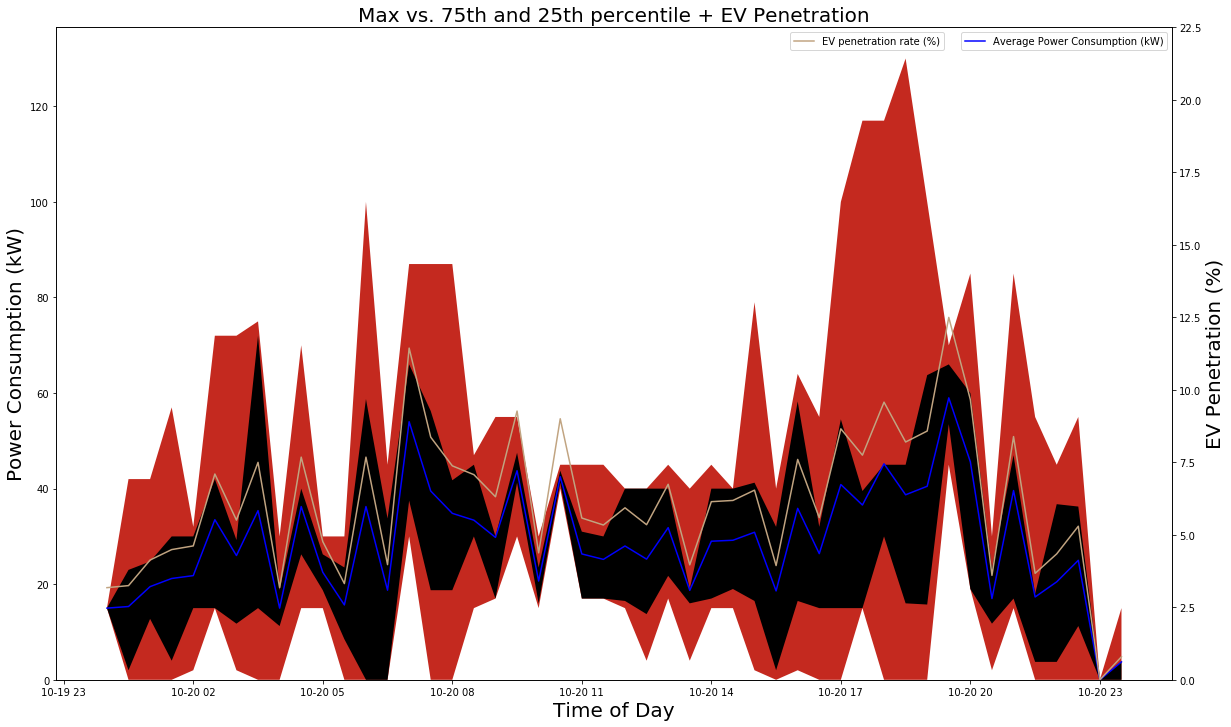

深圳湾美花园充电站 Shenzhen Bay US Garden Charging Station


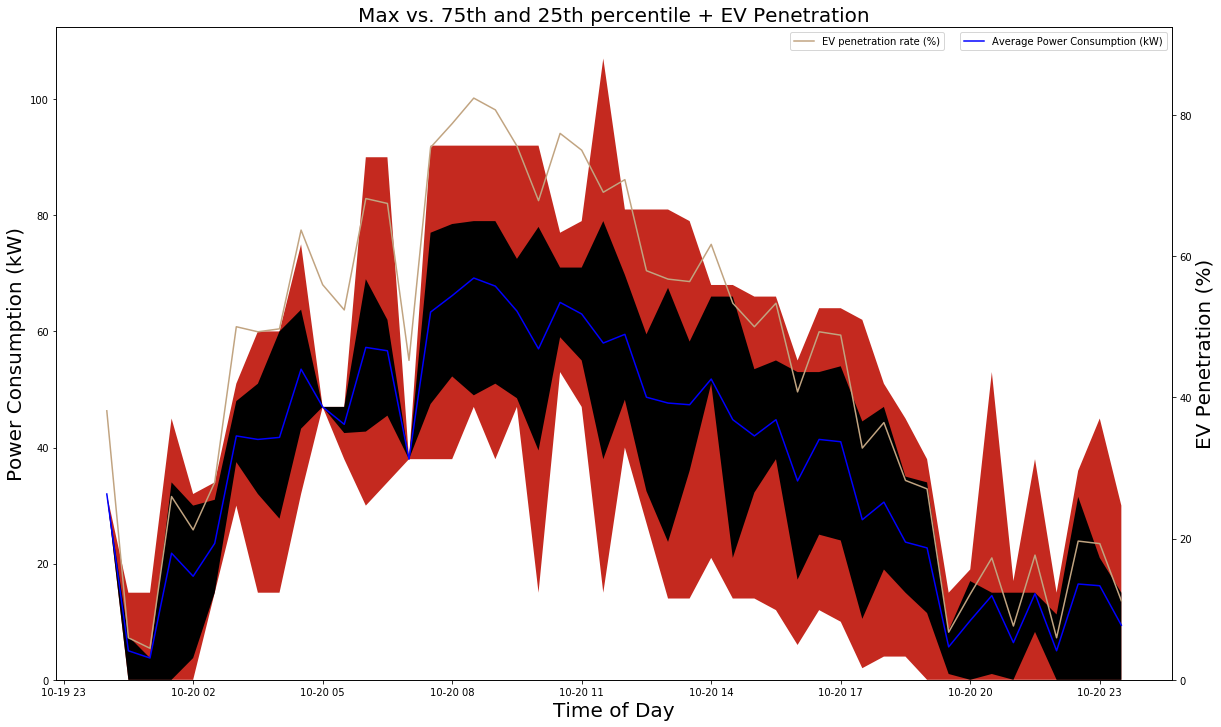

深圳金山大厦充电站 Shenzhen Jinshan Building Charging Station


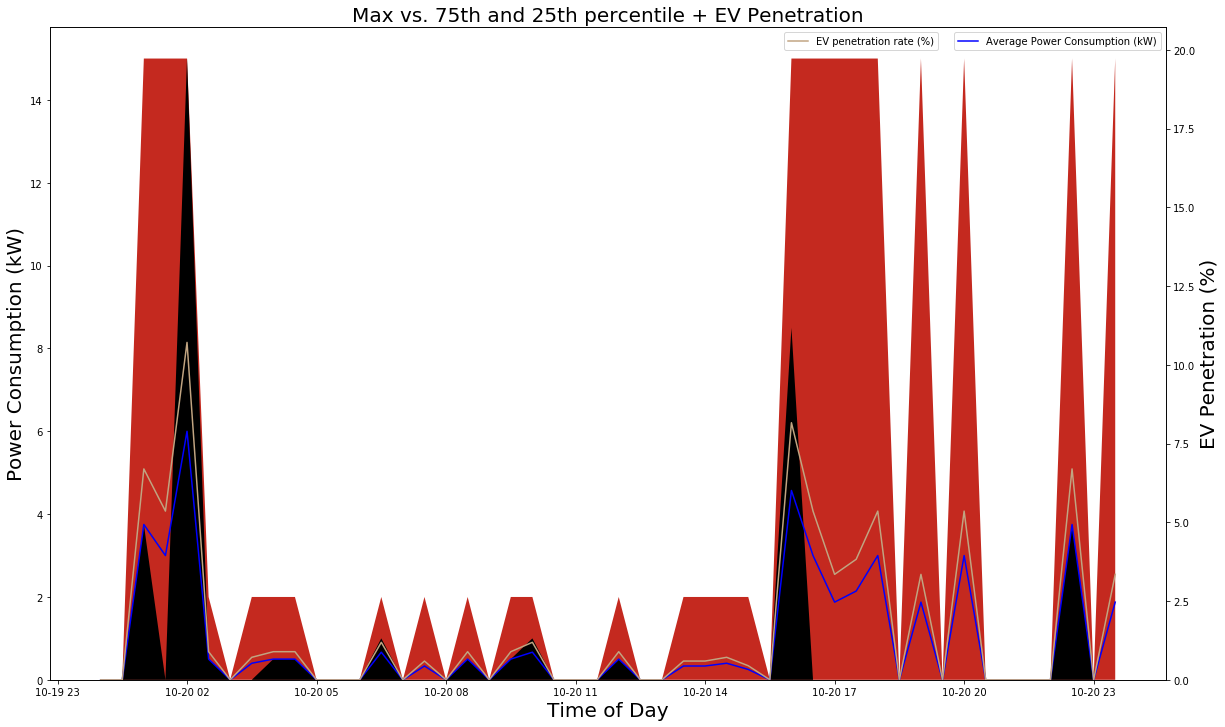

深圳万菱New寓充电站 Shenzhen million Ling new storage station


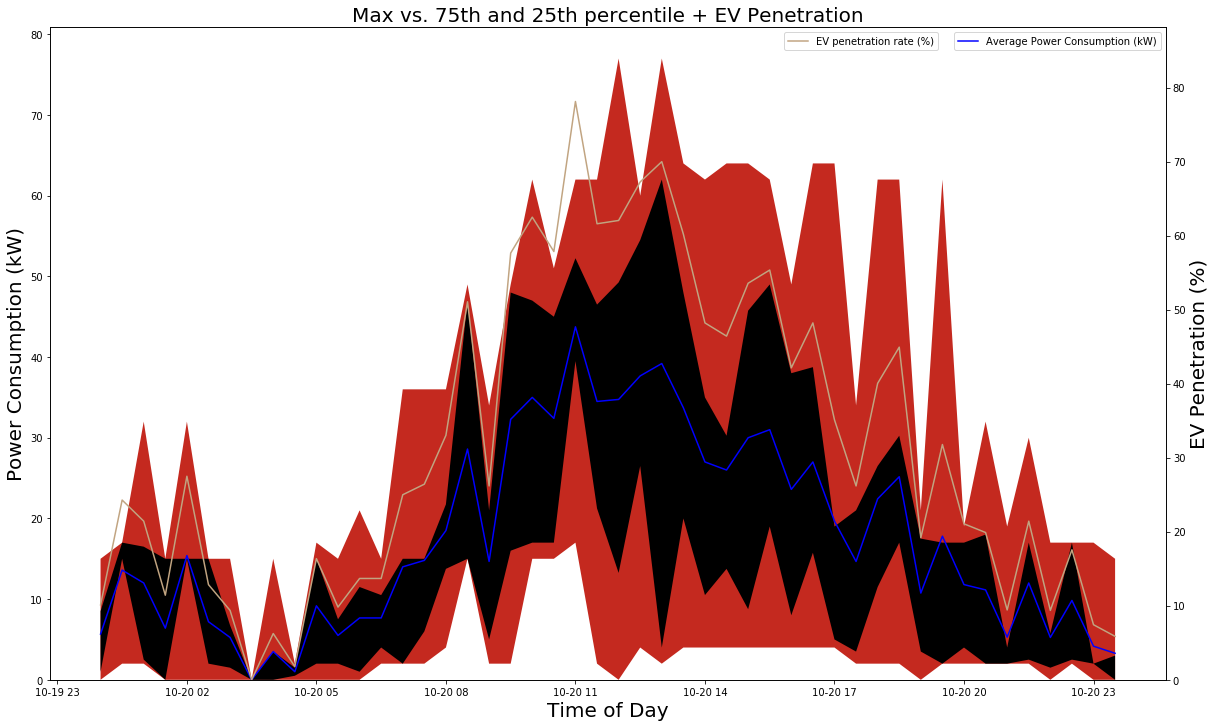

In [1091]:
main(sta_list_clean[0:30], timestamp_init=30, pen=1, save=0, eng=0)